Learn how to build Time Series models in TF. Implement best practices to prepare TS data. Explore how RNNs and 1D ConvNets can be used for prediction. Finally, apply everything learned throughout the Specialization to build a sunspot prediction model using real-world data!

# § 04.01. Sequences & Prediction

## Coding up TS

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras

In [ ]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
  plt.figure(figsize=(10, 7))
  plt.plot(time[start:end], series[start:end], format)
  plt.xlabel("Time")
  plt.ylabel("Value")
  if label:
    plt.legend(fontsize=14, labels=label)
  plt.grid(True)
  plt.show()

**Trend & Seasonality**

In [ ]:
def trend(time, slope=0):
  series = slope * time
  return series

Let's create a TS that just Trends upward:

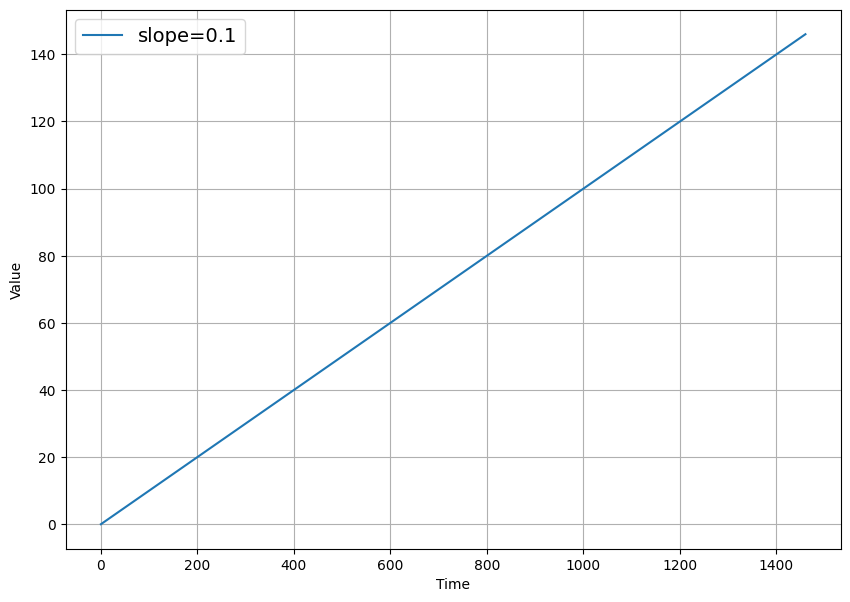

In [ ]:
time = np.arange(4 * 365 + 1)

slope = 0.1

series = trend(time, slope)

plot_series(time, series, label=[f"slope={slope}"])

Now let's generate a TS w/ a Seasonal pattern:

In [ ]:
def seasonal_pattern(season_time):
  # Just an arbitrary pattern
  data_pattern = np.where(season_time < 0.4,
                          np.cos(season_time * 2 * np.pi),
                          1 / np.exp(3 * season_time))
  return data_pattern

def seasonality(time, period, amplitude=1, phase=0):
  # Repeats the same pattern at each period
  season_time = ((time + phase) % period) / period
  data_pattern = amplitude * seasonal_pattern(season_time)
  return data_pattern

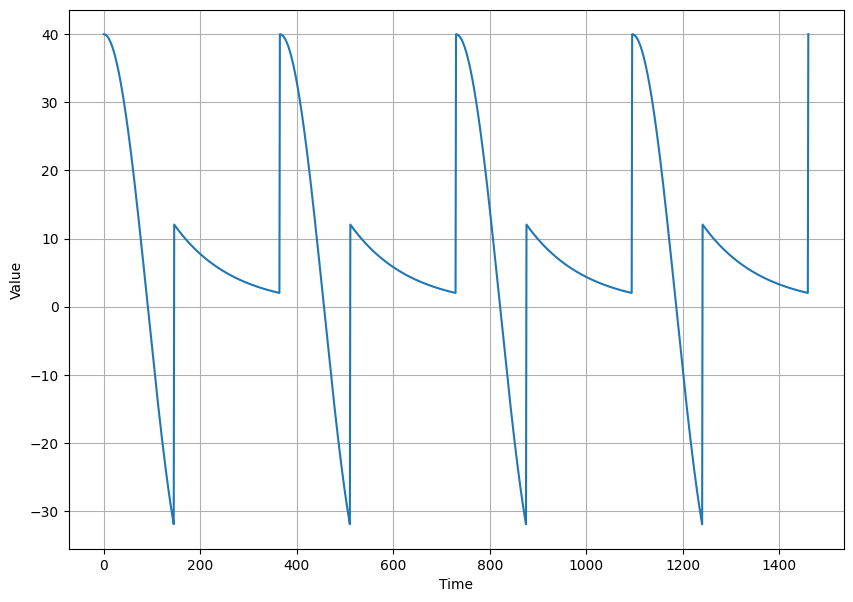

In [ ]:
period = 365
amplitude = 40
series = seasonality(time, period=period, amplitude=amplitude)

plot_series(time, series)

Now let's create a TS w/ both Trend & Seasonality:

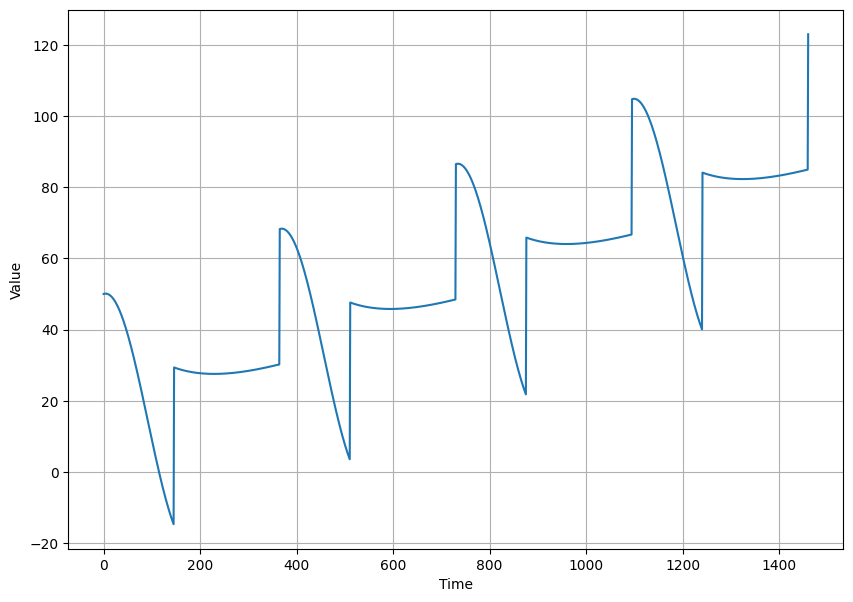

In [ ]:
intercept = 10
slope = 0.05
series = intercept + trend(time, slope) + seasonality(time, period=period, amplitude=amplitude)

plot_series(time, series)

**Noise**

In practice, few real-life TS have such a smooth signal. They usually have some noise, and the signal-to-noise ratioo can sometimes be very low. Let's generate some white noise:

In [ ]:
def white_noise(time, noise_level=1, seed=None):
  rnd = np.random.RandomState(seed)
  noise = rnd.randn(len(time)) * noise_level
  return noise

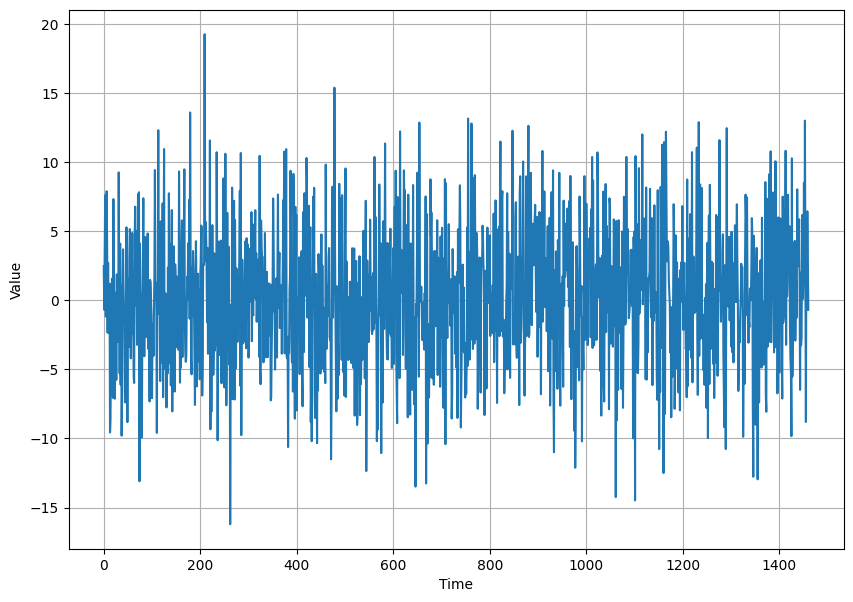

In [ ]:
noise_level = 5
noise_signal = white_noise(time, noise_level=noise_level, seed=42)

plot_series(time, noise_signal)

Now let's add this white noise to the TS:

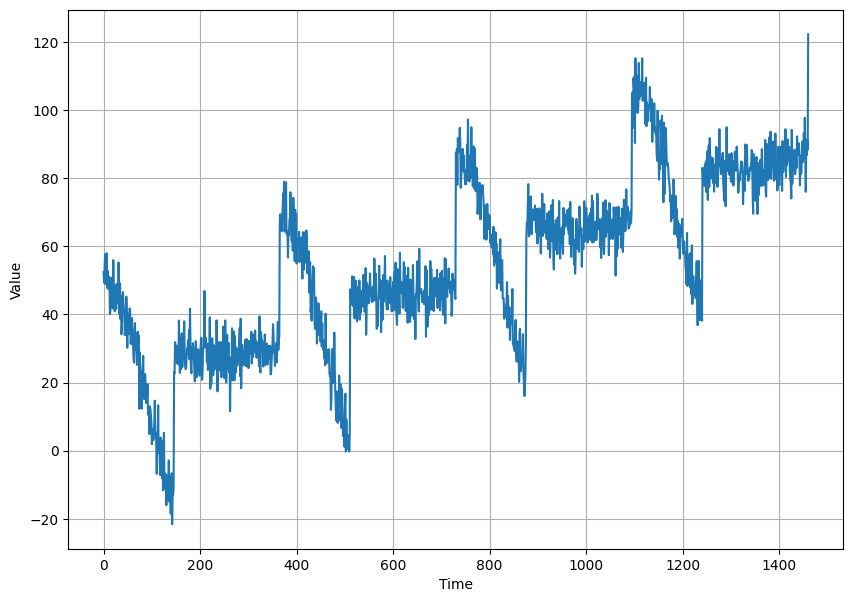

In [ ]:
series += noise_signal

plot_series(time, series)

This looks realistic enough for now. Let's try to forecast it--we will split it into 2 periods: the Training period & the Validation period (in many cases, you would also want to have a Test period); the split will be at time step 1,000.

In [ ]:
split_time = 1_000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [ ]:
def autocorrelation(time, amplitude, seed=None):
  rnd = np.random.RandomState(seed)
  phi1 = 0.5
  phi2 = -0.1

  ar = rnd.randn(len(time) + 50)
  ar[:50] = 100
  for step in range(50, len(time) + 50):
    ar[step] += phi1 * ar[step - 50]
    ar[step] += phi2 * ar[step - 33]
    ar = ar[50:] * amplitude
  return ar

In [ ]:
def autocorrelation(time, amplitude, seed=None):
  rnd = np.random.RandomState(seed)
  phi = 0.8
  ar = rnd.randn(len(time) + 1)
  for step in range(1, len(time) + 1):
    ar[step] += phi * ar[step - 1]
  ar = ar[1:] * amplitude

  return ar

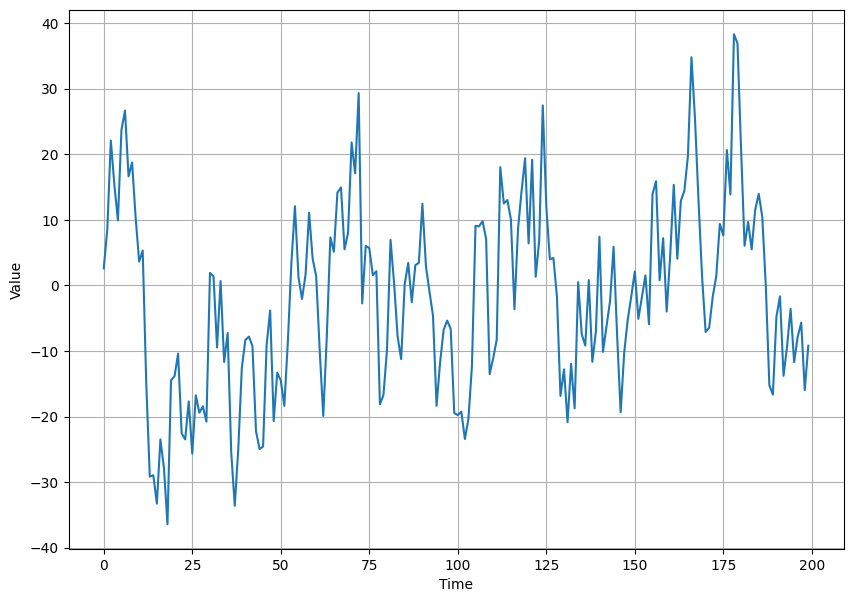

In [ ]:
series = autocorrelation(time, amplitude=10, seed=42)

plot_series(time[:200], series[:200])

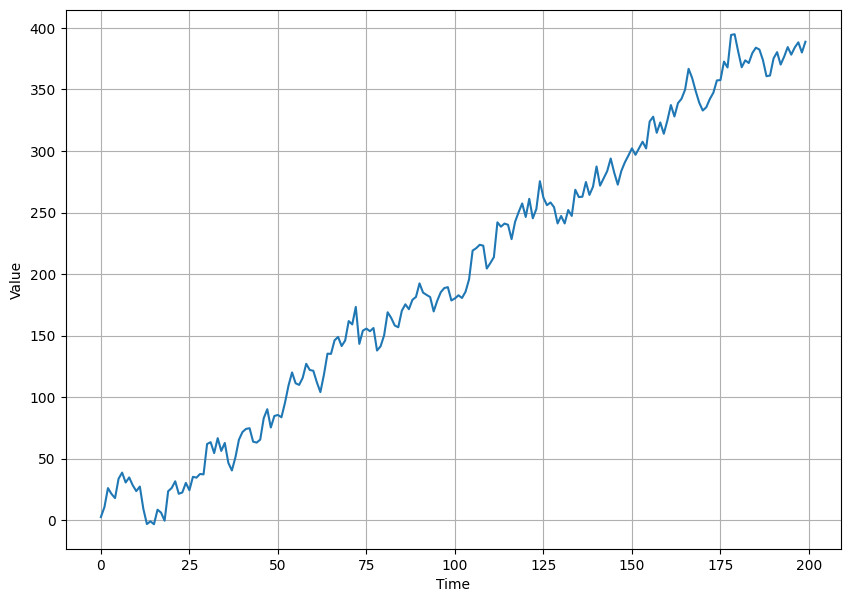

In [ ]:
series = autocorrelation(time, 10, seed=42) + trend(time, 2)

plot_series(time[:200], series[:200])

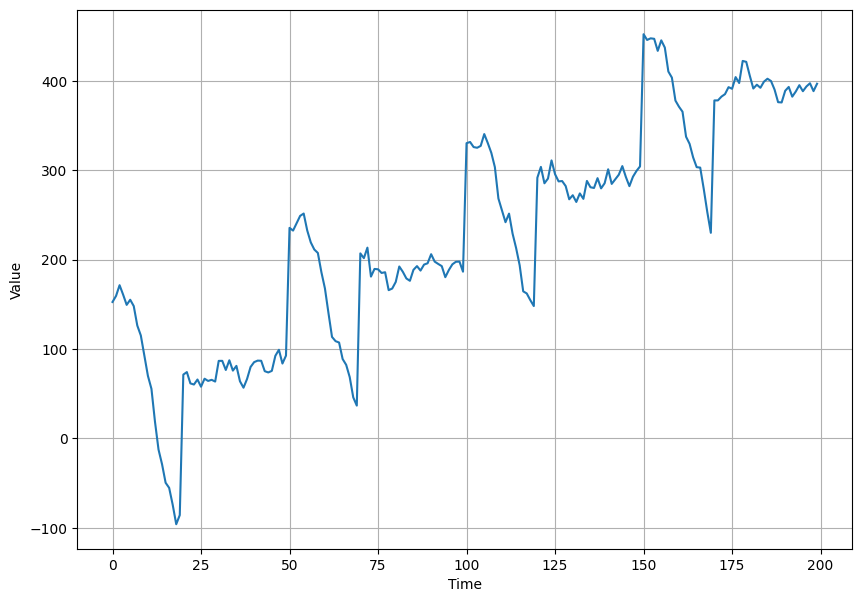

In [ ]:
series = autocorrelation(time, 10, seed=42) + seasonality(time, period=50, amplitude=150) + trend(time, 2)

plot_series(time[:200], series[:200])

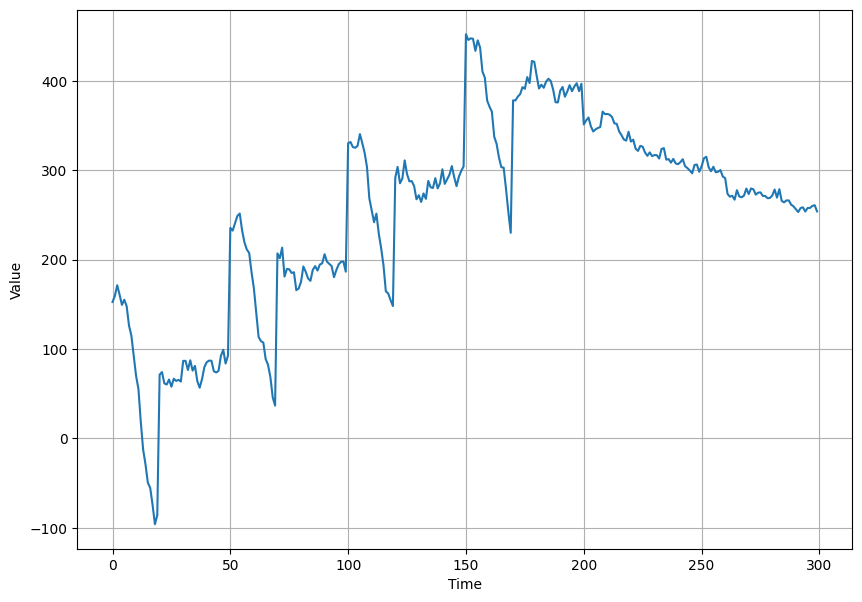

In [ ]:
series = autocorrelation(time, 10, seed=42) + seasonality(time, period=50, amplitude=150) + trend(time, 2)
series2 = autocorrelation(time, 5, seed=42) + seasonality(time, period=50, amplitude=2) + trend(time, -1) + 550
series[200:] = series2[200:]
# series += noise(time, 30)

plot_series(time[:300], series[:300])

In [ ]:
def impulses(time, num_impulses, amplitude=1, seed=None):
  rnd = np.random.RandomState(seed)
  impulse_indices = rnd.randint(len(time), size=num_impulses)
  series = np.zeros(len(time))
  for index in impulse_indices:
    series[index] += rnd.rand() * amplitude

  return series

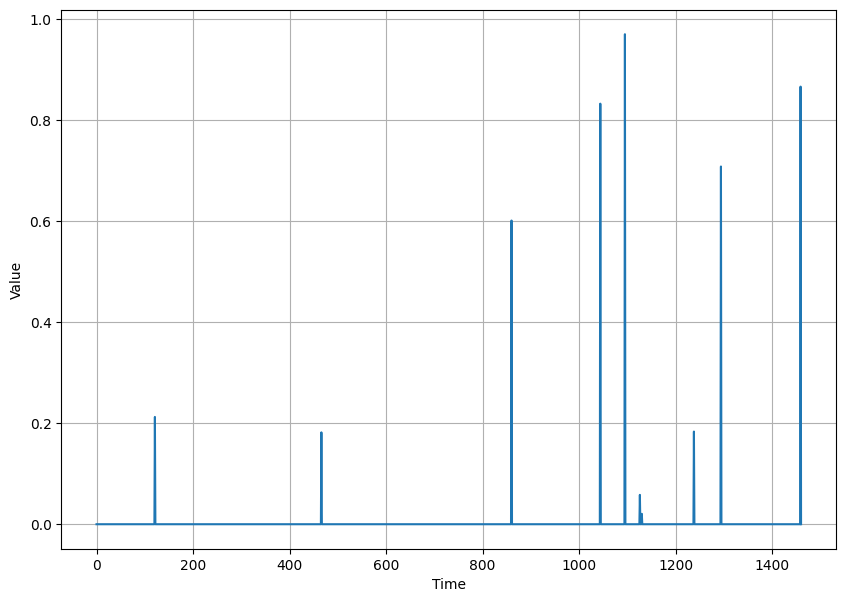

In [ ]:
impulses_signal = impulses(time, num_impulses=10, seed=42)

plot_series(time, impulses_signal)

In [ ]:
def autocorrelation(source, phis):
  ar = source.copy()

  for step, value in enumerate(source):
    for lag, phi in phis.items():
      if step - lag > 0:
        ar[step] += phi * ar[step - lag]
  return ar

In [ ]:
def plot_series2(time, series, format="-", start=0, end=None, label=None):
  # plt.figure(figsize=(10, 7))
  plt.plot(time[start:end], series[start:end], format)
  plt.xlabel("Time")
  plt.ylabel("Value")
  if label:
    plt.legend(fontsize=14, labels=label)
  plt.grid(True)
  # plt.show()

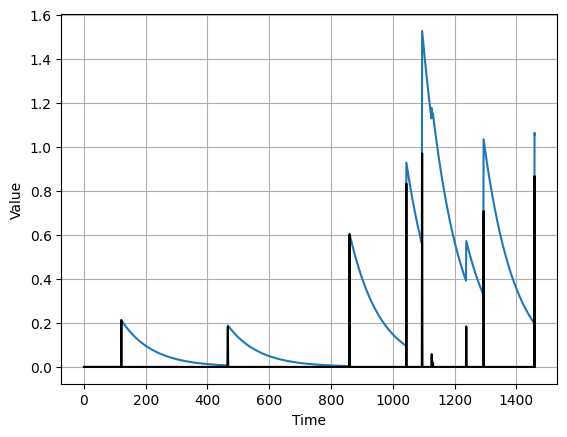

In [ ]:
signal = impulses(time, 10, seed=42)
series = autocorrelation(signal, {1: 0.99})

plot_series2(time, series)
plt.plot(time, signal, "k-")
plt.show()

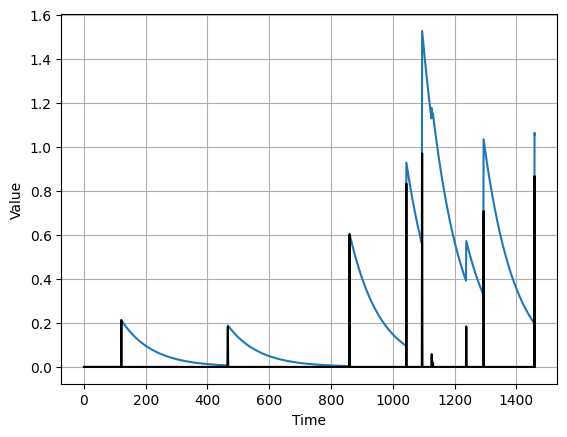

In [ ]:
signal = impulses(time, 10, seed=42)
series = autocorrelation(signal, {1: 0.99})

plot_series2(time, series)
plt.plot(time, signal, "k-")
plt.show()

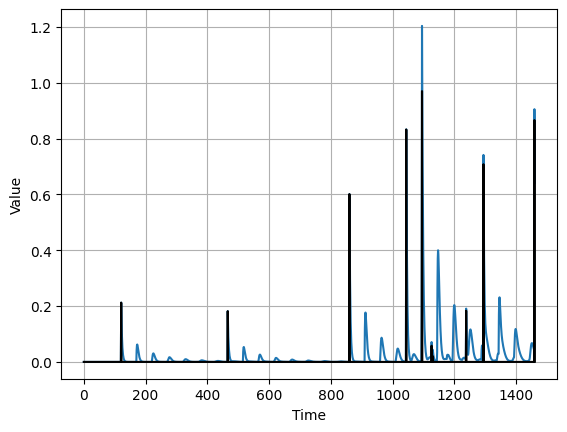

In [ ]:
signal = impulses(time, 10, seed=42)
series = autocorrelation(signal, {1 : 0.70, 50 : 0.2})

plot_series2(time, series)
plt.plot(time, signal, "k-")
plt.show()

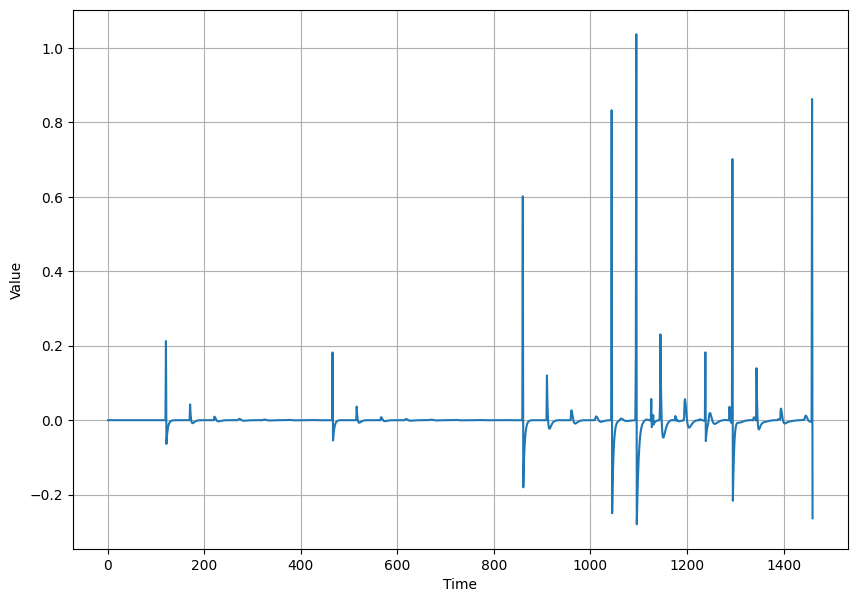

In [ ]:
series_diff1 = series[1:] - series[:-1]

plot_series(time[1:], series_diff1)

In [ ]:
from pandas.plotting import autocorrelation_plot

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

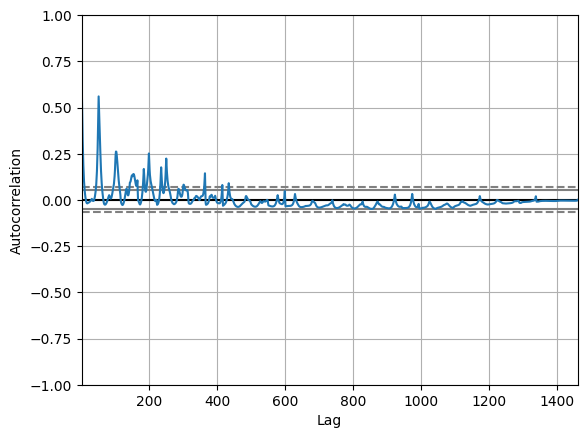

In [ ]:
autocorrelation_plot(series)

In [ ]:
import pandas as pd

In [ ]:
# Read a comma-separated values (csv) file into DataFrame
# pd.read_csv(filepath_or_buffer, sep=',', delimiter=None, header='infer', names=None, index_col=None, usecols=None,
#             squeeze=False, prefix=None, mangle_dupe_cols=True, dtype=None, engine=None, converters=None,
#             true_values=None, false_values=None, skipinitialspace=False, skiprows=None, skipfooter=0,
#             nrows=None, na_values=None, keep_default_na=True, na_filter=True, verbose=False, skip_blank_lines=True,
#             parse_dates=False, infer_datetime_format=False, keep_date_col=False, date_parser=None, dayfirst=False,
#             iterator=False, chunksize=None, compression='infer',
#             thousands=None, decimal=b'.', lineterminator=None, quotechar='"',
#             quoting=0, doublequote=True, escapechar=None, comment=None, encoding=None, dialect=None,
#             tupleize_cols=None, error_bad_lines=True, warn_bad_lines=True, delim_whitespace=False,
#             low_memory=True, memory_map=False, float_precision=None)

In [ ]:
from pandas.plotting import autocorrelation_plot

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

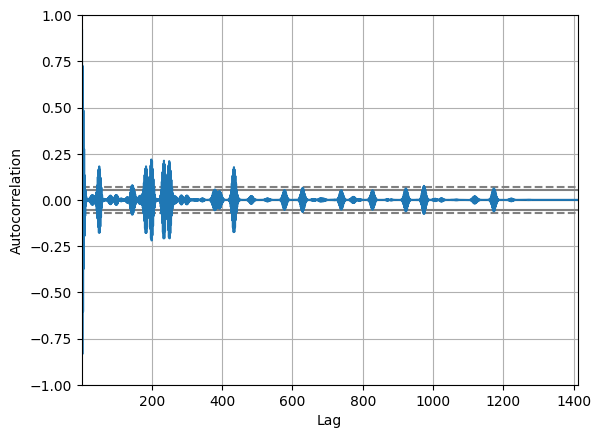

In [ ]:
series_diff = series

for lag in range(50):
  series_diff = series_diff[1:] - series_diff[:-1]

autocorrelation_plot(series_diff)

In [ ]:
import pandas as pd

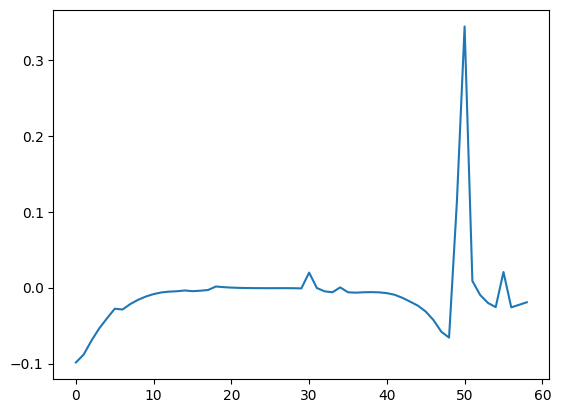

In [ ]:
series_diff1 = pd.Series(series[1:] - series[:-1])
autocorrs = [series_diff1.autocorr(lag) for lag in range(1, 60)]

plt.plot(autocorrs)
plt.show()

## Forecasting

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras

The next code blocks will set up the TS w/ Seasonality, Trend and a bit of Noise:

In [ ]:
def plot_series(time, series, format="-", start=0, end=None):
  plt.figure(figsize=(10, 6))
  if type(series) is tuple:
    for series_num in series:
      plt.plot(time[start:end], series_num[start:end], format)
  else:
    plt.plot(time[start:end], series[start:end], format)

  plt.xlabel("Time")
  plt.ylabel("Value")
  plt.grid(True)
  plt.show()

In [ ]:
def trend(time, slope=0):
  series = slope * time
  return series

In [ ]:
def seasonal_pattern(season_time):
  # Just an arbitrary pattern
  data_pattern = np.where(season_time < 0.4,
                          np.cos(season_time * 2 * np.pi),
                          1 / np.exp(3 * season_time))
  return data_pattern

def seasonality(time, period, amplitude=1, phase=0):
  # Repeats the same pattern at each period
  season_time = ((time + phase) % period) / period
  data_pattern = amplitude * seasonal_pattern(season_time)
  return data_pattern

In [ ]:
def noise(time, noise_level=1, seed=None):
  rnd = np.random.RandomState(seed)
  noise = rnd.randn(len(time)) * noise_level
  return noise

Use the utility functions above to *generate the synthetic data*. Start at a **Baseline**, then **Trend** upwards w/ a **Seasonal** pattern every 365 steps, and also add some **Noise**, because the real-world data is often noisy as well.

In [ ]:
# Parameters
time = np.arange(4 * 365 + 1, dtype="float32")

intercept = 10
amplitude = 40
slope = 0.05
noise_level = 5

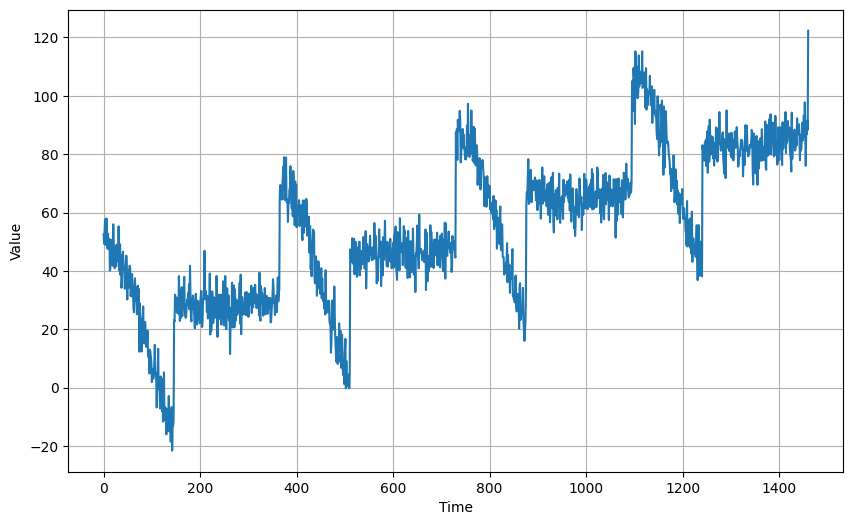

In [ ]:
# Create the series
series = intercept + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update w/ noise
series += noise(time, noise_level, seed=42)

plot_series(time, series)

Now that we have the TS, let's split it so we can start forecasting:

In [ ]:
split_time = 1_000

time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

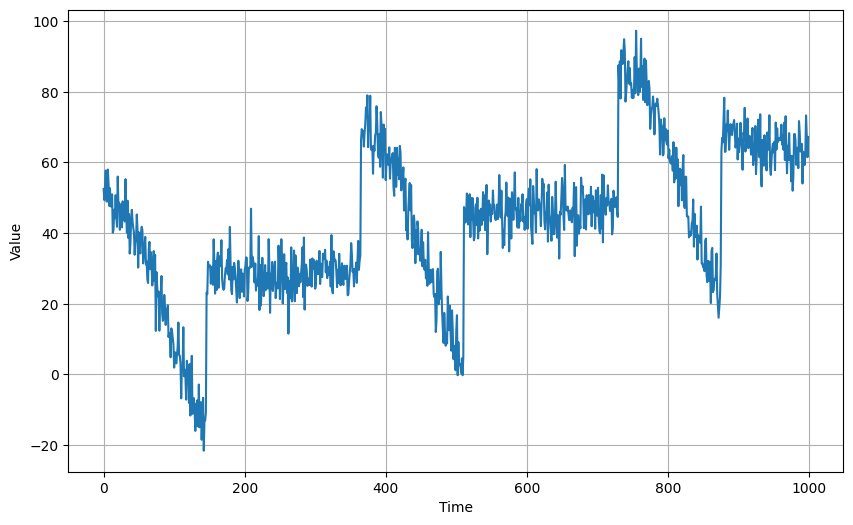

In [ ]:
plot_series(time_train, x_train)

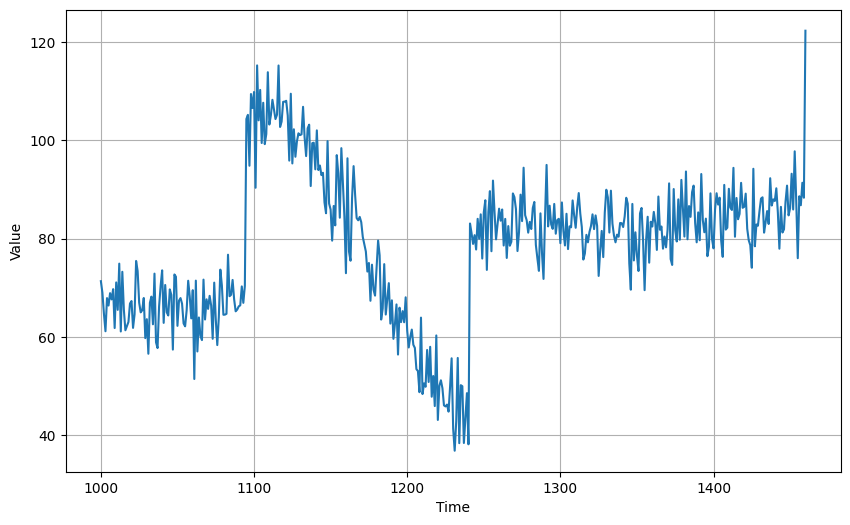

In [ ]:
plot_series(time_valid, x_valid)

As a baseline, we now do a **Naive Forecast**, where we assume that the next value will be the same as the previous time step. Slice the original series and print some values as a sanity check, then the next time step value should be identical to the *Ground Truth* at the previous time step:

In [ ]:
naive_forecast = series[split_time - 1 : -1]

time_step = 100

print(f"Ground Truth at time step {time_step}: {x_valid[time_step]}")
print(f"Prediction at time step {time_step + 1}: {naive_forecast[time_step + 1]}")

Ground Truth at time step 100: 109.84197998046875
Prediction at time step 101: 109.84197998046875


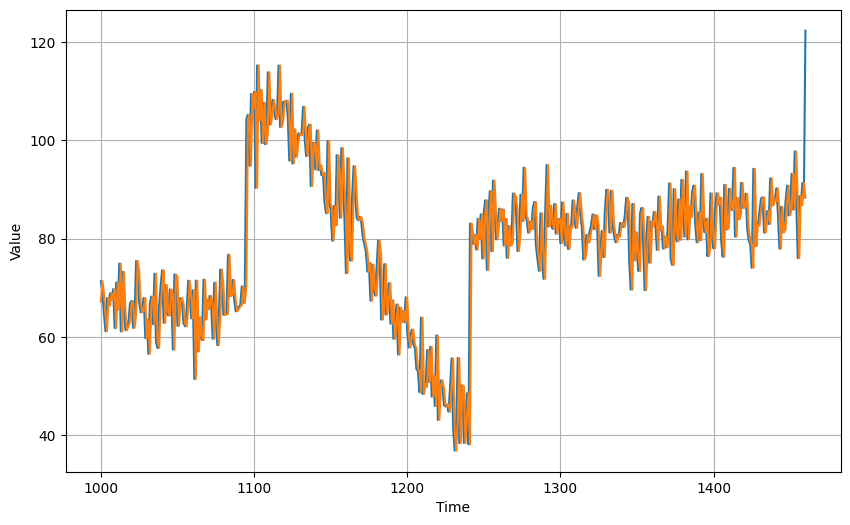

In [ ]:
plot_series(time_valid, (x_valid, naive_forecast))

Let's zoom in on the start of the Validation period:

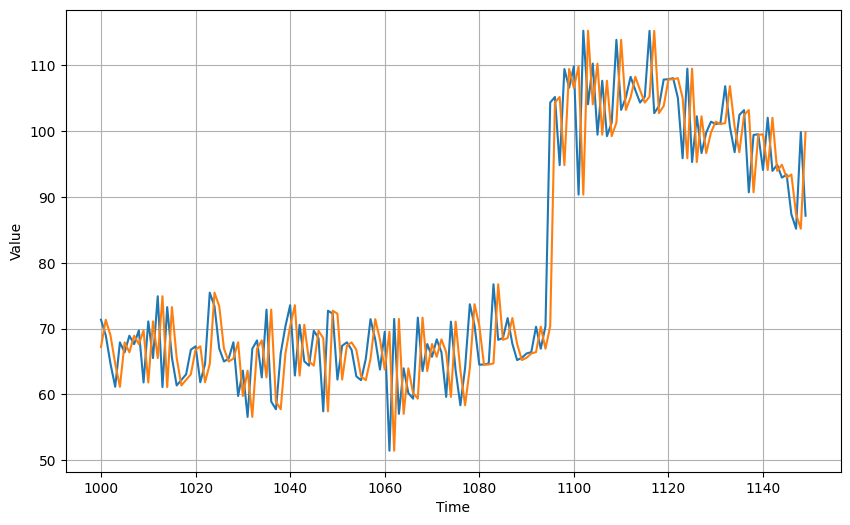

In [ ]:
plot_series(time_valid, (x_valid, naive_forecast), start=0, end=150)

You can see that the naive forecast lags 1 step behind the TS.

Now let's compute the MSE & the MAE bw. the forecast and the predictions in the Validation period:

In [ ]:
print(keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy())
print(keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy())

61.827534
5.937908


That's our Baseline, now let's try a **MA**:

In [ ]:
def moving_average_forecast(series, window_size):
  """Forecasts the mean of the last few values.
     If window_size=1, then this is equiv. to naive forecast."""
  forecast = []
  for time in range(len(series) - window_size):
    forecast.append(series[time : time + window_size].mean())
  forecast = np.array(forecast)

  return forecast

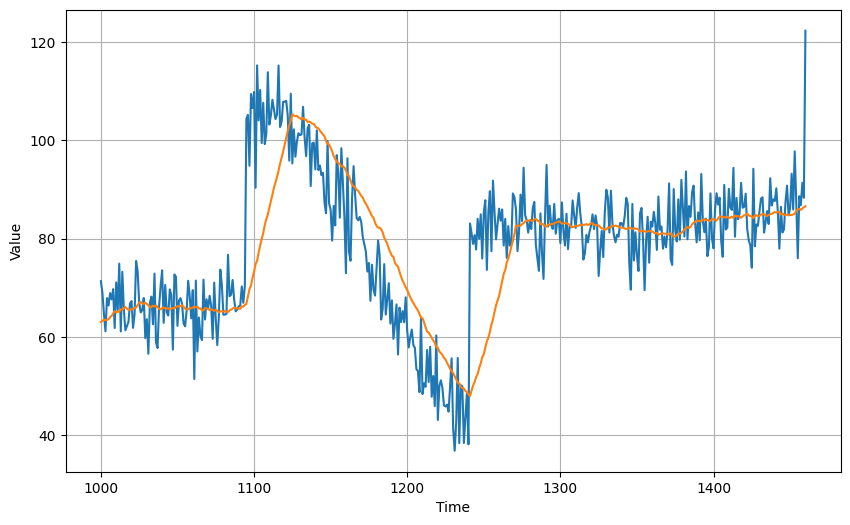

In [ ]:
moving_avg = moving_average_forecast(series, 30)[split_time - 30 :]


plot_series(time_valid, (x_valid, moving_avg))

In [ ]:
print(keras.metrics.mean_squared_error(x_valid, moving_avg).numpy())
print(keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy())

106.674576
7.142419


That's worse than Naive Forecast! The MA does not anticipate Trend or Seasonality, so let's try to remove them by using **Differencing**. Since the Seasonality period is 365 days, we will subtract the value at time [*t* - 365] from the value at time [*t*].

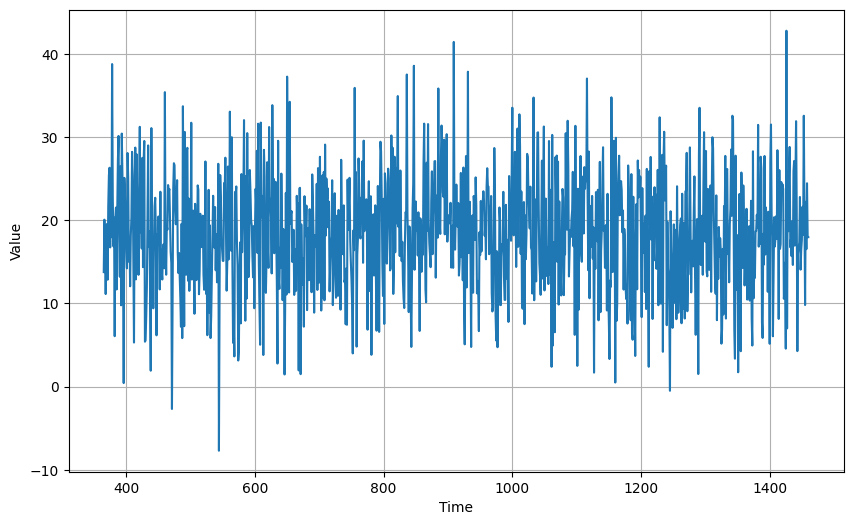

In [ ]:
diff_series = (series[365:] - series[:-365])
diff_time = time[365:]

plot_series(diff_time, diff_series)

Great, the Trend and Seasonality seem to be gone, so now we can use the MA:

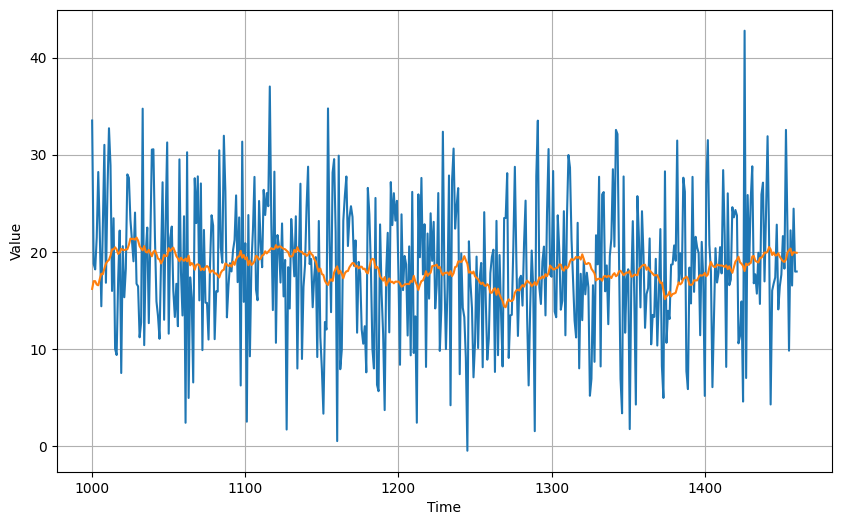

In [ ]:
# Generate MA from the time Differenced dataset
diff_moving_avg = moving_average_forecast(diff_series, 30)

# Slice the Prediction points that correspond to the Validation set time steps
diff_moving_avg = diff_moving_avg[split_time - 365 - 30 :]

# Slice the Ground Truth points that correspond to the Validation set time steps
diff_series = diff_series[split_time - 365 :]

plot_series(time_valid, (diff_series, diff_moving_avg))

Now let's bring back the Trens and Seasonality by adding the past values from [*t* - 365]:

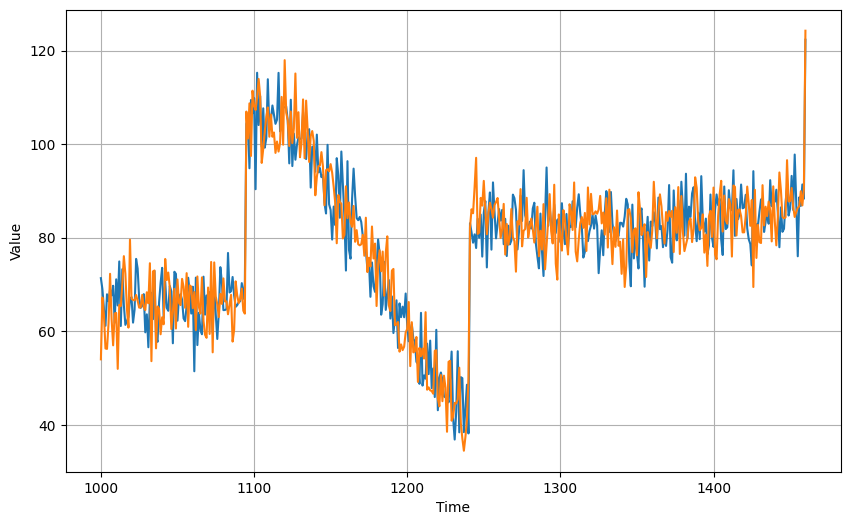

In [ ]:
diff_moving_avg_plus_past = series[split_time - 365 : -365] + diff_moving_avg

plot_series(time_valid, (x_valid, diff_moving_avg_plus_past))

In [ ]:
print(keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_past).numpy())
print(keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_past).numpy())

53.764587
5.9032416


Better than Naive Forecast, good! However, the forecast looks a bit too random, because we're just adding past values, which were noisy. Let's use a MA on past values to **Smooth** out some of the noise:

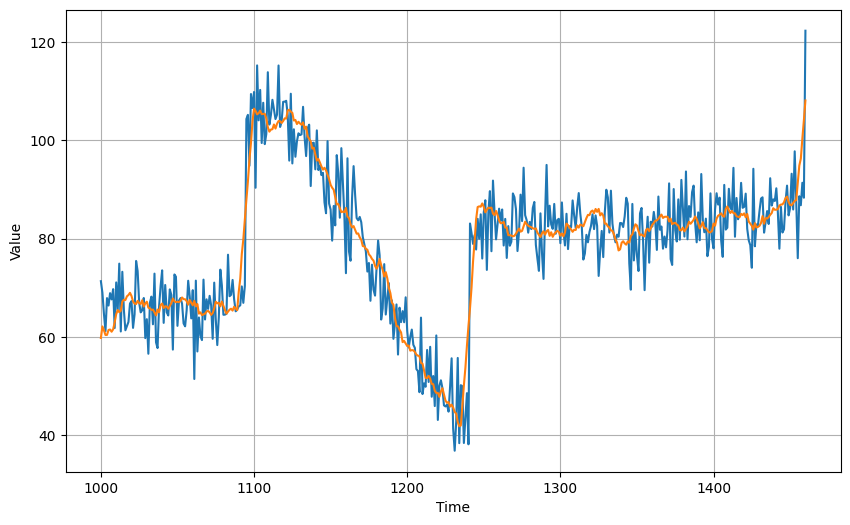

In [ ]:
# Smooth the original series, before adding the time differenced MA
diff_moving_avg_plus_smooth_past = moving_average_forecast(series[split_time - 370 : -359], 11) + diff_moving_avg

plot_series(time_valid, (x_valid, diff_moving_avg_plus_smooth_past))

In [ ]:
print(keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())
print(keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())

34.315723
4.6053295


## Ex. 1) Synthetic Data Series

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras

In [ ]:
def plot_series(time, series, format="-", title="", label=None, start=0, end=None):
  """Plot the series."""
  plt.plot(time[start:end], series[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("Value")
  plt.title(title)
  if label:
    plt.legend()
  plt.grid(True)

def trend(time, slope=0):
  """A trend over time."""
  return slope * time

def seasonal_pattern(season_time):
  """Just an arbitrary pattern."""
  return np.where(season_time < 0.1,
                  np.cos(season_time * 7 * np.pi),
                  1 / np.exp(5 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
  """Repeats the same pattern at each period."""
  season_time = ((time + phase) % period) / period
  return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
  """Adds noise to the series."""
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time)) * noise_level

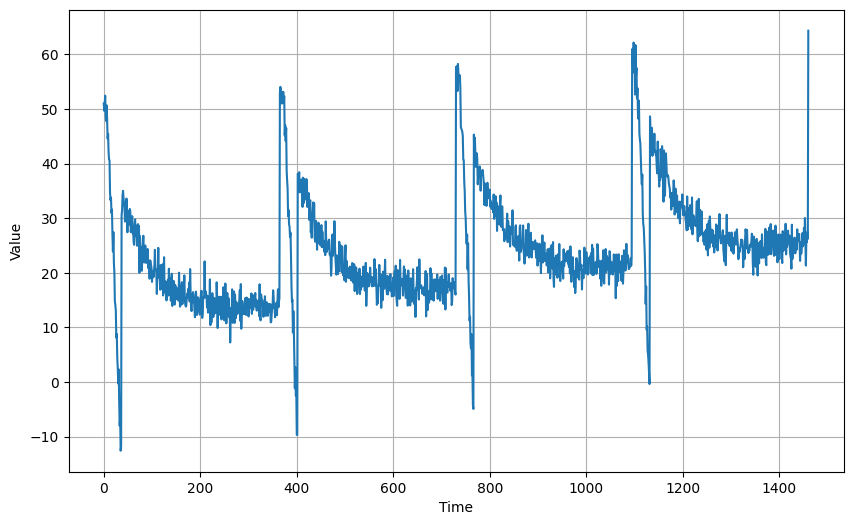

In [ ]:
time = np.arange(4 * 365 + 1, dtype="float32")

intercept = 10
slope = 0.01
series = intercept + trend(time, slope)

amplitude = 40
series += seasonality(time, period=365, amplitude=amplitude)

noise_level = 2
series += noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

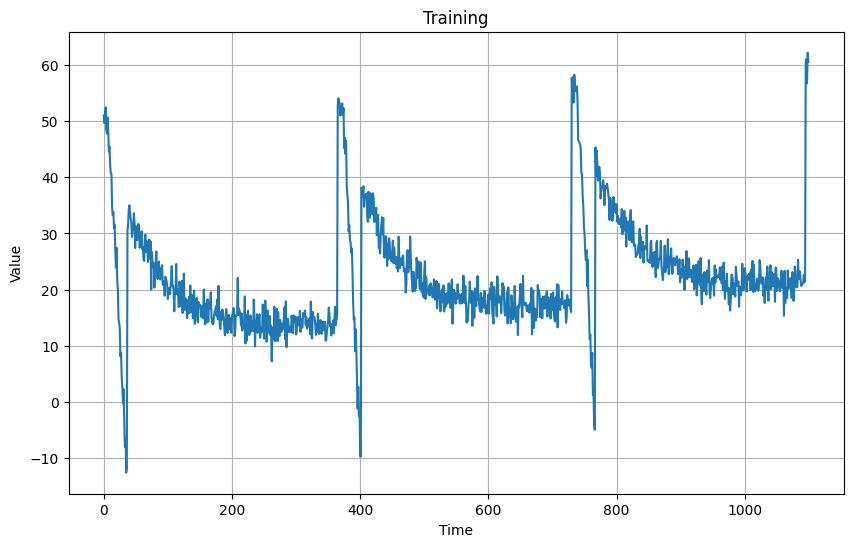

In [ ]:
split_time = 1_100

time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

plt.figure(figsize=(10, 6))
plot_series(time_train, x_train, title="Training")
plt.show()

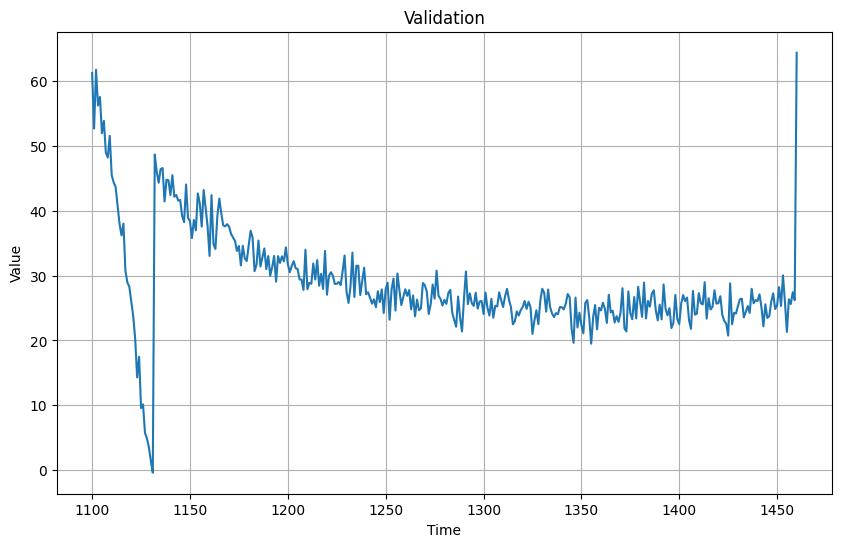

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, title="Validation")
plt.show()

In [ ]:
print(keras.metrics.mean_squared_error(time_valid, x_valid).numpy())
print(keras.metrics.mean_absolute_error(time_valid, x_valid).numpy())

1576973.9
1251.0741


In [ ]:
def compute_metrics(true_series, forecast):
  mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
  mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

  return mse, mae

In [ ]:
mse, mae = compute_metrics(time_valid, x_valid)

In [ ]:
naive_forecast = series[split_time - 1 : -1]

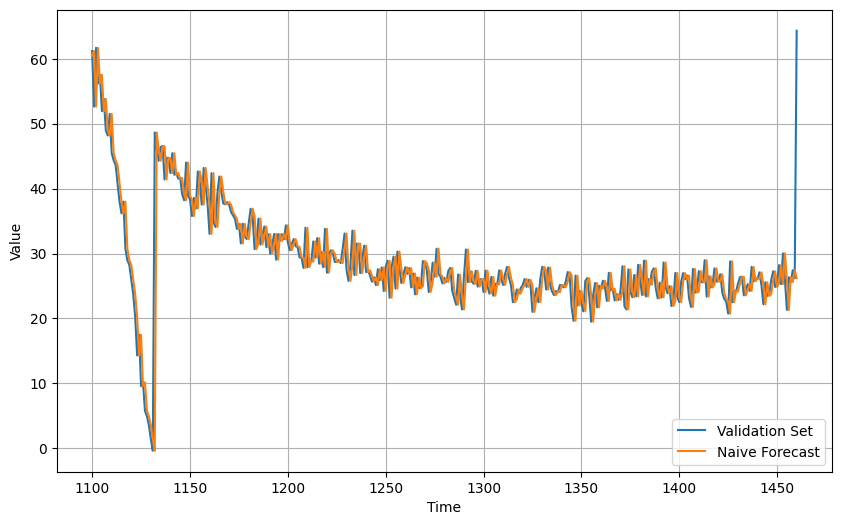

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label="Validation Set")

plot_series(time_valid, naive_forecast, label="Naive Forecast")

Let's zoom in on the start of the Validation period:

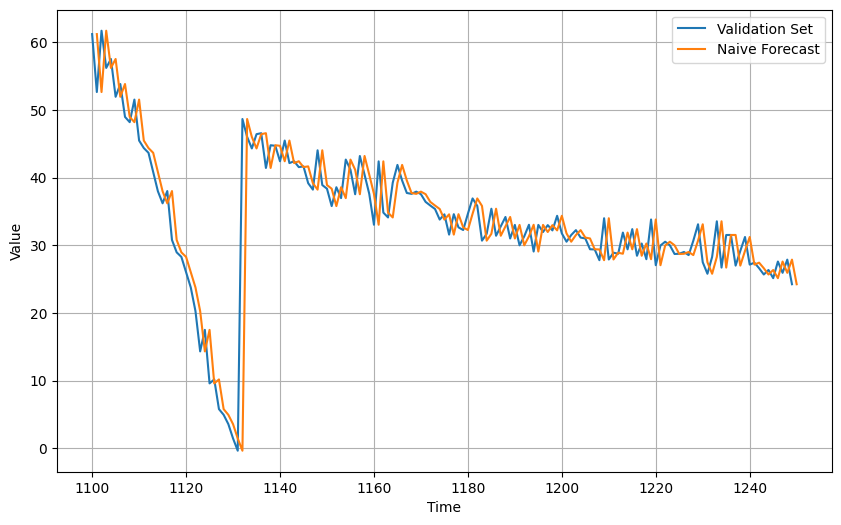

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, start=0, end=150, label="Validation Set")

plot_series(time_valid, naive_forecast, start=1, end=151, label="Naive Forecast")

Let's zoom in on the end of the Validation period:

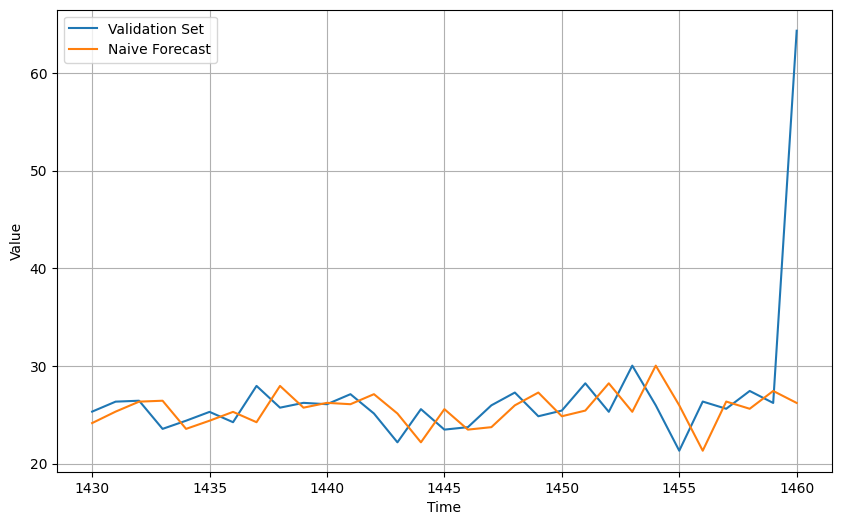

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, start=330, end=361, label="Validation Set")

plot_series(time_valid, naive_forecast, start=330, end=361, label="Naive Forecast")

The Naive Forecast langs 1 step behind the TS.

Now, let's compute the MSE & the MAE bw. the forecasts and the predictions in the Validation period:

In [ ]:
# print(keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy())
# print(keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy())

mse, mae = compute_metrics(x_valid, naive_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for naive forecast")

mse: 19.58, mae: 2.60 for naive forecast


That's our Baseline, now let's try a MA:

In [ ]:
def moving_average_forecast(series, window_size):
  """Forecasts the mean of the last few values.
     If window_size=1, then this is equivalent to naive forecast."""
  forecast = []
  for time in range(len(series) - window_size):
    forecast.append(series[time : time + window_size].mean())
  return np.array(forecast)

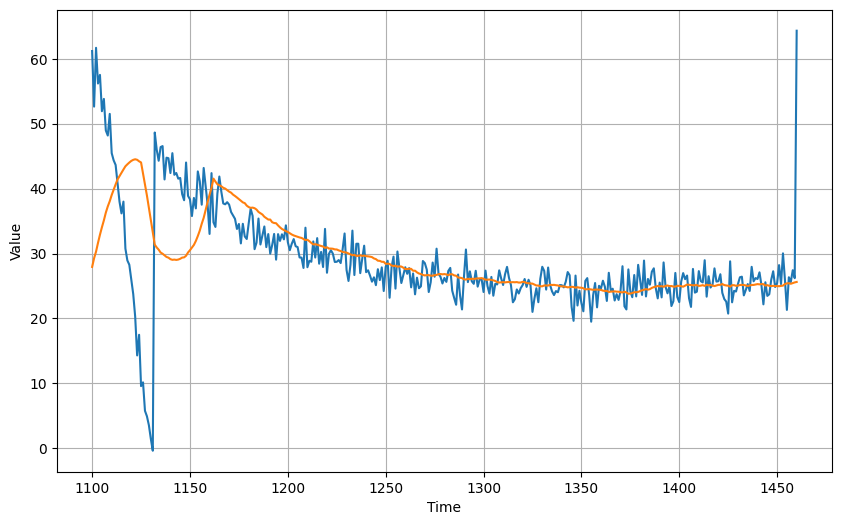

In [ ]:
moving_avg = moving_average_forecast(series, 30)[split_time - 30 :]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)

plot_series(time_valid, moving_avg)

In [ ]:
# print(keras.metrics.mean_squared_error(x_valid, moving_avg).numpy())
# print(keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy())

mse, mae = compute_metrics(x_valid, moving_avg)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for moving average forecast")

mse: 65.79, mae: 4.30 for moving average forecast


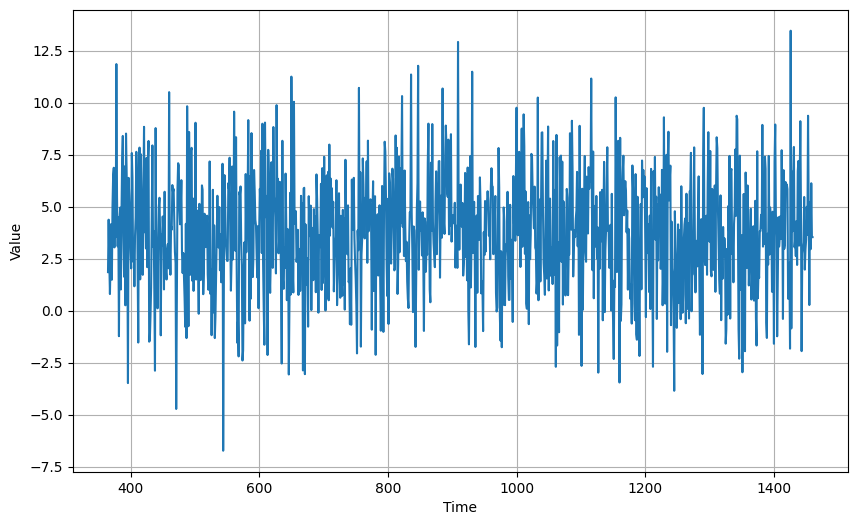

In [ ]:
diff_series = (series[365:] - series[:-365])
diff_time = time[365:]

plt.figure(figsize=(10, 6))
plot_series(diff_time, diff_series)
plt.show()

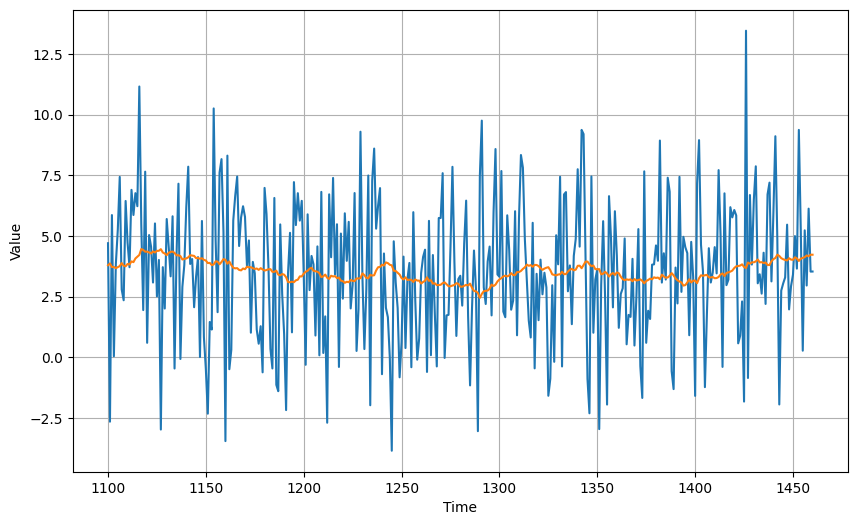

In [ ]:
diff_moving_avg = moving_average_forecast(diff_series, 50)[split_time - 365 - 50 :]

plt.figure(figsize=(10, 6))
plot_series(time_valid, diff_series[split_time - 365 :])

plot_series(time_valid, diff_moving_avg)
plt.show()

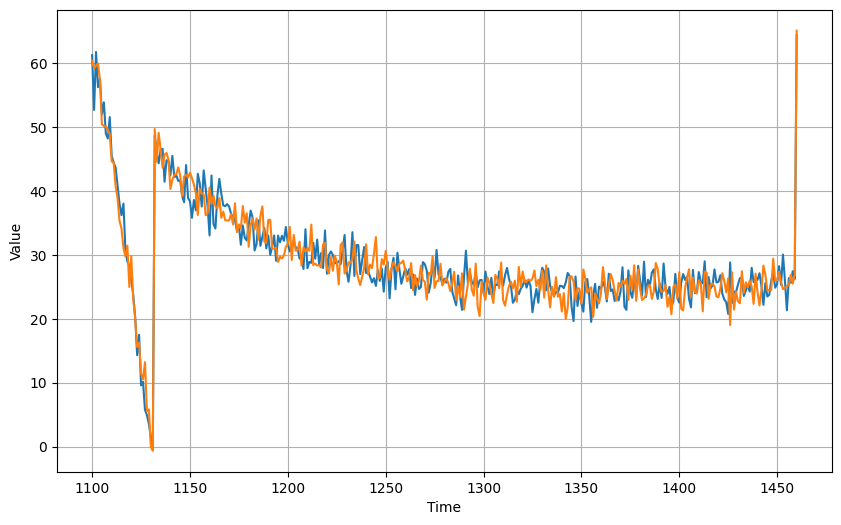

In [ ]:
diff_moving_avg_plus_past = series[split_time - 365 : -365] + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)

plot_series(time_valid, diff_moving_avg_plus_past)
plt.show()

In [ ]:
# print(keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_past).numpy())
# print(keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_past).numpy())

mse, mae = compute_metrics(x_valid, diff_moving_avg_plus_past)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for moving average plus past forecast")

mse: 8.50, mae: 2.33 for moving average plus past forecast


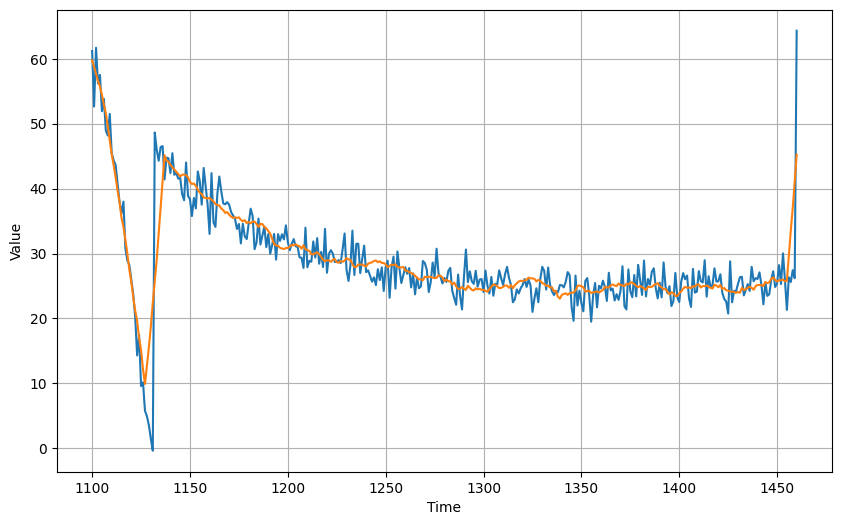

In [ ]:
diff_moving_avg_plus_smooth_past = moving_average_forecast(series[split_time - 370 : -360], 10) + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)

plot_series(time_valid, diff_moving_avg_plus_smooth_past)
plt.show()

In [ ]:
# print(keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())
# print(keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())

mse, mae = compute_metrics(x_valid, diff_moving_avg_plus_smooth_past)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for moving average plus smooth past forecast")

mse: 12.53, mae: 2.20 for moving average plus smooth past forecast


# § 04.02. DNNs for Time Series

## Preparing Features & Labels

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
dataset = tf.data.Dataset.range(10)

for val in dataset:
  print(val.numpy())

0
1
2
3
4
5
6
7
8
9


In [ ]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1)

for window_dataset in dataset:
  for val in window_dataset:
    print(val.numpy(), end=" ")
  print()

0 1 2 3 4 
1 2 3 4 5 
2 3 4 5 6 
3 4 5 6 7 
4 5 6 7 8 
5 6 7 8 9 
6 7 8 9 
7 8 9 
8 9 
9 


In [ ]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)

for window_dataset in dataset:
  for val in window_dataset:
    print(val.numpy(), end=" ")
  print()

0 1 2 3 4 
1 2 3 4 5 
2 3 4 5 6 
3 4 5 6 7 
4 5 6 7 8 
5 6 7 8 9 


In [ ]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))

for window in dataset:
  print(window.numpy())

[0 1 2 3 4]
[1 2 3 4 5]
[2 3 4 5 6]
[3 4 5 6 7]
[4 5 6 7 8]
[5 6 7 8 9]


In [ ]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))

for x, y in dataset:
  print(x.numpy(), y.numpy())

[0 1 2 3] [4]
[1 2 3 4] [5]
[2 3 4 5] [6]
[3 4 5 6] [7]
[4 5 6 7] [8]
[5 6 7 8] [9]


In [ ]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.shuffle(buffer_size=10)

for x, y in dataset:
  print(x.numpy(), y.numpy())

[3 4 5 6] [7]
[4 5 6 7] [8]
[1 2 3 4] [5]
[2 3 4 5] [6]
[5 6 7 8] [9]
[0 1 2 3] [4]


In [ ]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.shuffle(buffer_size=10)
dataset = dataset.batch(2).prefetch(1)

for x, y in dataset:
  print("x = ", x.numpy())
  print("y = ", y.numpy())

x =  [[3 4 5 6]
 [5 6 7 8]]
y =  [[7]
 [9]]
x =  [[1 2 3 4]
 [4 5 6 7]]
y =  [[5]
 [8]]
x =  [[0 1 2 3]
 [2 3 4 5]]
y =  [[4]
 [6]]


## Single-Layer NN

In [ ]:
def plot_series(time, series, format="-", start=0, end=None):
  plt.figure(figsize=(10, 6))
  if type(series) is tuple:
    for series_num in series:
      plt.plot(time[start:end], series_num[start:end], format)
  else:
    plt.plot(time[start:end], series[start:end], format)
  plt.xlabel("Time")
  plt.ylabel("Value")
  plt.grid(True)
  plt.show()

def trend(time, slope=0):
  return slope * time

def seasonal_pattern(season_time):
  return np.where(season_time < 0.4,
                  np.cos(season_time * 2 * np.pi),
                  1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
  season_time = ((time + phase) % period) / period
  return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time)) * noise_level

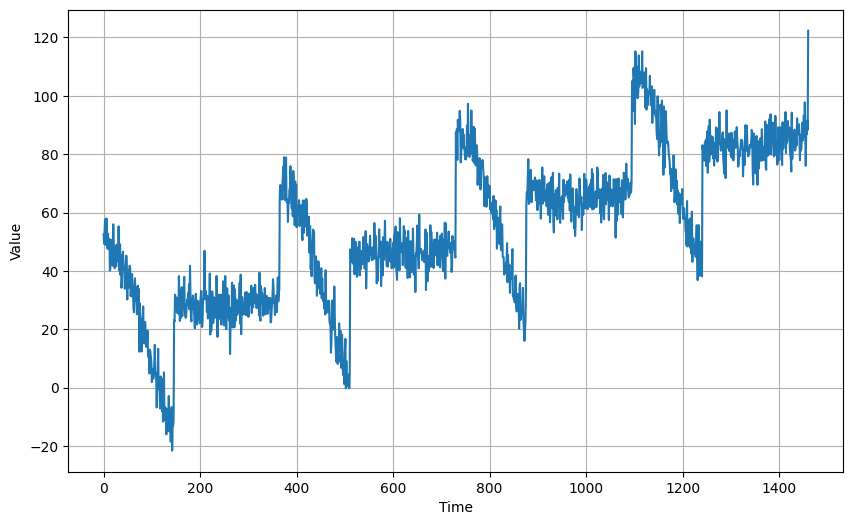

In [ ]:
time = np.arange(4 * 365 + 1, dtype="float32")
intercept = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = intercept + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update w/ noise
series += noise(time, noise_level, seed=42)

# Plot the results
plot_series(time, series)

In [ ]:
split_time = 1_000

time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

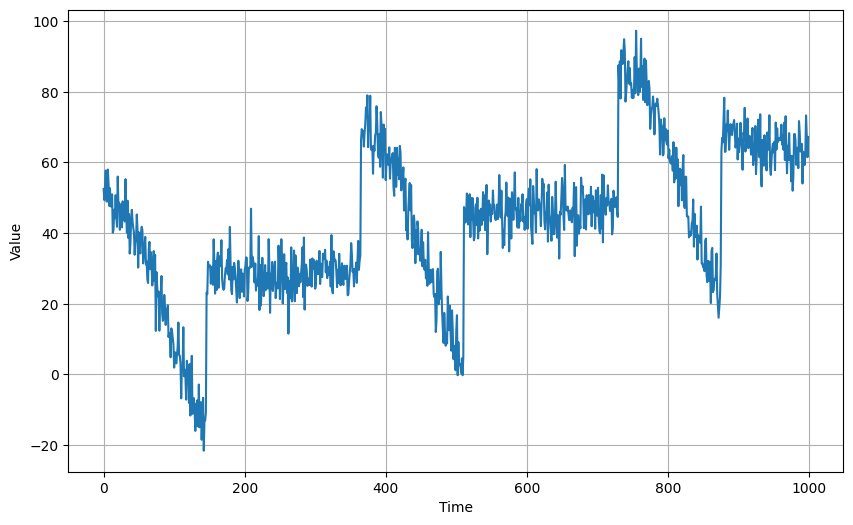

In [ ]:
plot_series(time_train, x_train)

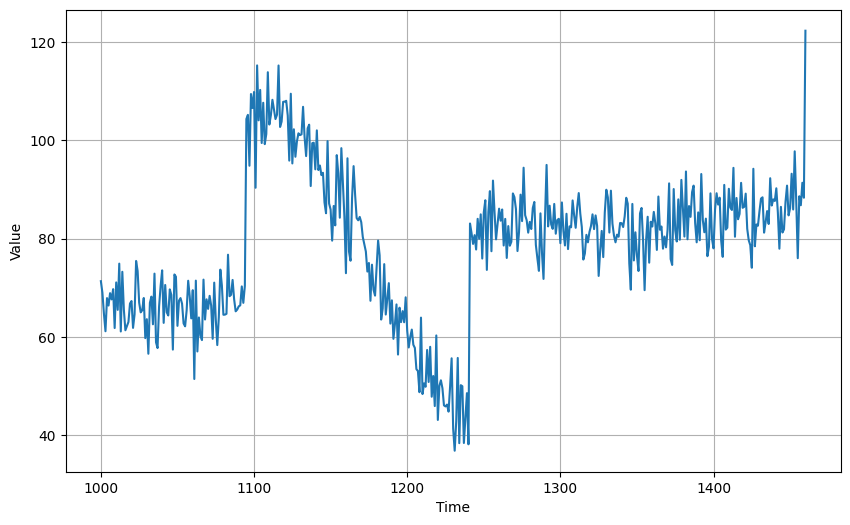

In [ ]:
plot_series(time_valid, x_valid)

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  # Generate the dataset from the series
  dataset = tf.data.Dataset.from_tensor_slices(series)
  # Window the data, but only take those w/ the specified size
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  # Flatten the windows, by putting its elements in a single batch
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  # Create tuples (features, labels)
  dataset = dataset.map(lambda window: (window[:-1], window[-1]))
  # Shuffle the windows
  dataset = dataset.shuffle(shuffle_buffer)
  # Create batches of windows
  dataset = dataset.batch(batch_size).prefetch(1)

  return dataset

In [ ]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1_000

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(dataset)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>


In [ ]:
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model_1L = tf.keras.models.Sequential([l0])

print("Layer weights {}".format(l0.get_weights()))

model_1L.summary()

Layer weights [array([[-0.10341036],
       [ 0.49376696],
       [-0.0882622 ],
       [-0.36283875],
       [-0.26567307],
       [-0.14262125],
       [ 0.45331436],
       [ 0.25455713],
       [ 0.26571578],
       [-0.10895693],
       [-0.481813  ],
       [ 0.1497575 ],
       [ 0.20140696],
       [-0.0255999 ],
       [ 0.01570034],
       [ 0.09041137],
       [ 0.30532873],
       [ 0.32395065],
       [ 0.21725857],
       [-0.11642149]], dtype=float32), array([0.], dtype=float32)]
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 1)                 21        
                                                                 
Total params: 21 (84.00 Byte)
Trainable params: 21 (84.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model_1L.compile(loss="mse",
                 optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))

model_1L.fit(dataset,
             epochs=100)

Epoch 1/100
31/31 [==============================] - 1s 3ms/step - loss: 101.1715
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 97.3385
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 92.9513
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 91.3521
Epoch 5/100
31/31 [==============================] - 0s 2ms/step - loss: 88.1978
Epoch 6/100
31/31 [==============================] - 0s 2ms/step - loss: 85.9628
Epoch 7/100
31/31 [==============================] - 0s 3ms/step - loss: 83.9370
Epoch 8/100
31/31 [==============================] - 0s 3ms/step - loss: 82.5903
Epoch 9/100
31/31 [==============================] - 0s 3ms/step - loss: 80.8267
Epoch 10/100
31/31 [==============================] - 0s 2ms/step - loss: 78.9964
Epoch 11/100
31/31 [==============================] - 0s 2ms/step - loss: 77.5130
Epoch 12/100
31/31 [==============================] - 0s 1ms/step - loss: 75.5933
Epoch 13/100
31/31 [====

In [ ]:
forecast = []

for time in range(len(series) - window_size):
  forecast.append(model_1L.predict(series[time : time + window_size][np.newaxis]))

forecast = forecast[split_time - window_size :]
results = np.array(forecast).squeeze()

1/1 [==============================] - 0s 41ms/step


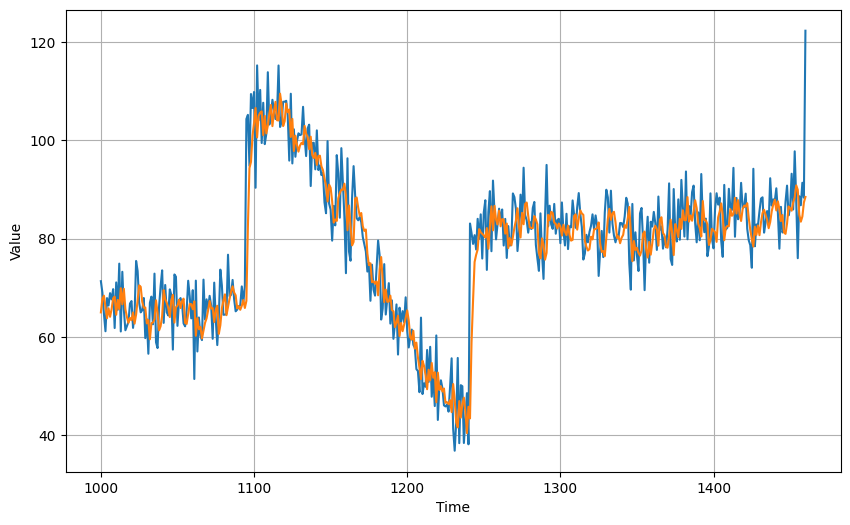

In [ ]:
plot_series(time_valid, (x_valid, results))

In [ ]:
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

45.50458
4.9368067


## DNN

In [ ]:
model_DNN = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

print("Layer weights {}".format(l0.get_weights()))

model_DNN.summary()

Layer weights [array([[-0.0753781 ],
       [ 0.07613013],
       [ 0.02768503],
       [-0.04924706],
       [-0.01470453],
       [-0.01848389],
       [ 0.04592739],
       [ 0.03227651],
       [ 0.01953219],
       [-0.00174709],
       [-0.09178242],
       [ 0.03091785],
       [ 0.0025572 ],
       [ 0.0201952 ],
       [-0.00434644],
       [ 0.04761434],
       [ 0.06834373],
       [ 0.19073659],
       [ 0.28691056],
       [ 0.3964241 ]], dtype=float32), array([0.01487679], dtype=float32)]
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 10)                210       
                                                                 
 dense_6 (Dense)             (None, 10)                110       
                                                                 
 dense_7 (Dense)             (None, 1)                 11        
        

In [ ]:
model_DNN.compile(loss="mse",
                  optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))

model_DNN.fit(dataset,
              epochs=100)

Epoch 1/100
31/31 [==============================] - 1s 3ms/step - loss: 101.8518
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 77.8223
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 73.0451
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 68.7396
Epoch 5/100
31/31 [==============================] - 0s 3ms/step - loss: 66.3415
Epoch 6/100
31/31 [==============================] - 0s 3ms/step - loss: 65.5512
Epoch 7/100
31/31 [==============================] - 0s 4ms/step - loss: 62.6173
Epoch 8/100
31/31 [==============================] - 0s 4ms/step - loss: 61.4790
Epoch 9/100
31/31 [==============================] - 0s 2ms/step - loss: 60.8257
Epoch 10/100
31/31 [==============================] - 0s 2ms/step - loss: 59.2572
Epoch 11/100
31/31 [==============================] - 0s 2ms/step - loss: 58.1784
Epoch 12/100
31/31 [==============================] - 0s 2ms/step - loss: 57.1921
Epoch 13/100
31/31 [====

In [ ]:
forecast = []

for time in range(len(series) - window_size):
  forecast.append(model_DNN.predict(series[time : time + window_size][np.newaxis]))

forecast = forecast[split_time - window_size :]
results = np.array(forecast).squeeze()

1/1 [==============================] - 0s 37ms/step


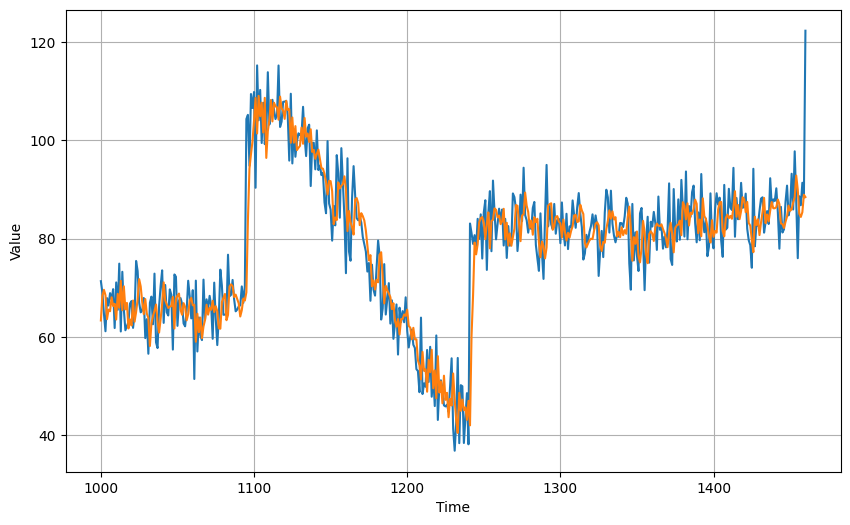

In [ ]:
plot_series(time_valid, (x_valid, results))

In [ ]:
tf.keras.metrics.mean_squared_error(x_valid, results).numpy()
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.0370607

In [ ]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20)
)

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)

model_DNN.compile(loss="mse",
                  optimizer=optimizer)

history_DNN = model_DNN.fit(dataset,
                            epochs=100,
                            callbacks=[lr_schedule],
                            verbose=0)

(1e-08, 0.001, 0.0, 300.0)

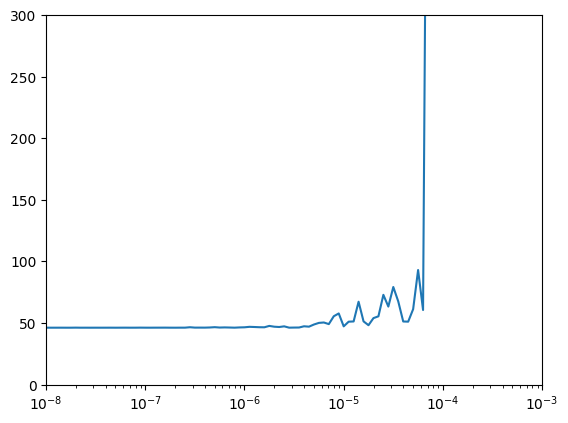

In [ ]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

plt.semilogx(lrs, history_DNN.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

In [ ]:
window_size = 30

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(dataset)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>


In [ ]:
model_DNN = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=7e-6, momentum=0.9)

model_DNN.compile(loss="mse",
                  optimizer=optimizer)

history_DNNw = model_DNN.fit(dataset,
                              epochs=500,
                              verbose=0)

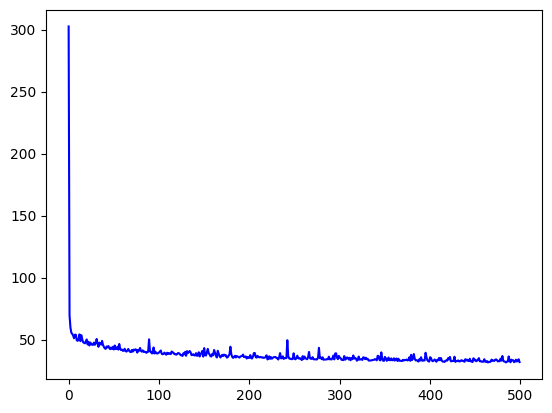

In [ ]:
loss = history_DNNw.history['loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

[49.0018196105957, 50.42821502685547, 54.19040298461914, 48.78520202636719, 53.58464813232422, 50.49448013305664, 47.91141128540039, 47.437232971191406, 47.00034713745117, 48.63009262084961, 50.16521453857422, 46.108402252197266, 48.262359619140625, 45.25345993041992, 47.65398025512695, 46.41350555419922, 45.77642059326172, 45.85906219482422, 47.609981536865234, 45.820457458496094, 47.4929084777832, 50.52638626098633, 46.75526809692383, 44.19651794433594, 47.49604034423828, 46.935279846191406, 45.92009735107422, 48.99456787109375, 45.78528594970703, 44.18967819213867, 43.00766372680664, 42.535919189453125, 44.45279312133789, 43.72886657714844, 44.81508255004883, 43.120548248291016, 42.328269958496094, 43.57532501220703, 42.58895492553711, 44.21503829956055, 42.03901290893555, 45.281211853027344, 42.405494689941406, 42.48472595214844, 44.29317855834961, 41.91885757446289, 46.506996154785156, 42.80557632446289, 41.55778121948242, 41.96856689453125, 40.97047424316406, 41.041996002197266, 

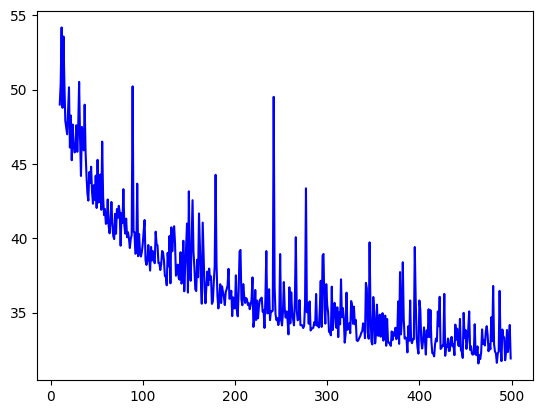

In [ ]:
# Plot all, but the first 10
loss = history_DNNw.history['loss']
epochs = range(10, len(loss))

plot_loss = loss[10:]
print(plot_loss)

plt.plot(epochs, plot_loss, 'b', label='Traning Loss')
plt.show()

In [ ]:
forecast = []

for time in range(len(series) - window_size):
  forecast.append(model_DNN.predict(series[time : time + window_size][np.newaxis]))

forecast = forecast[split_time - window_size :]
results = np.array(forecast).squeeze()

1/1 [==============================] - 0s 109ms/step


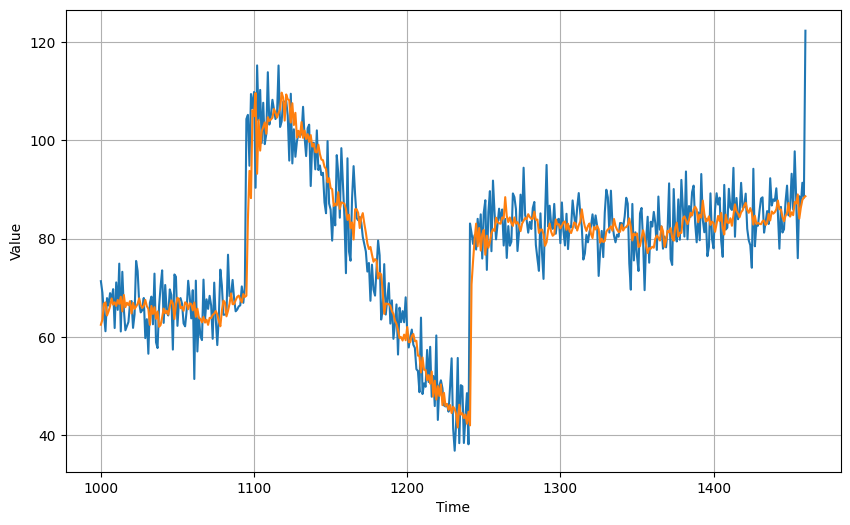

In [ ]:
plot_series(time_valid, (x_valid, results))

In [ ]:
# print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

4.689683


## Ex. 2) Prediction using DNN

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from dataclasses import dataclass

In [ ]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """An arbitrary pattern"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi),
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

In [ ]:
time = np.arange(4 * 365 + 1, dtype="float32")
intercept = 10
slope = 0.005
series = intercept + trend(time, slope)

amplitude = 50
series += seasonality(time, period=365, amplitude=amplitude)

noise_level = 3
series += noise(time, noise_level, seed=51)

split_time = 1_100

time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

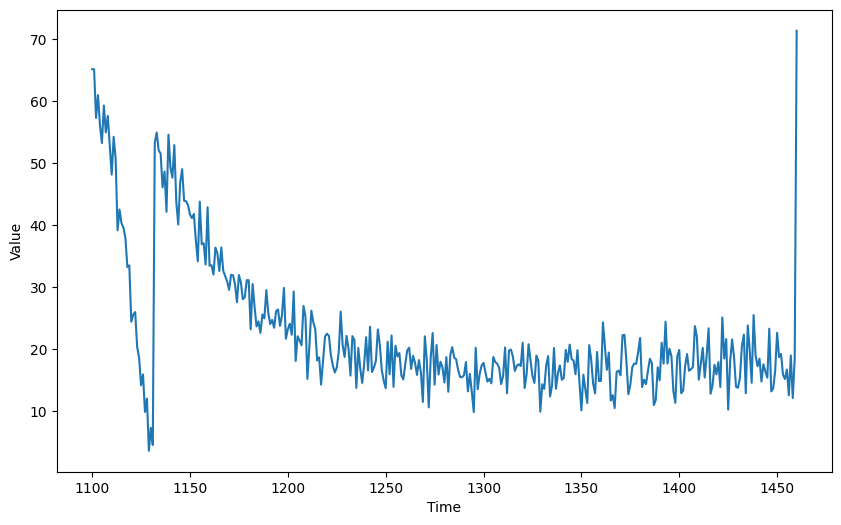

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [ ]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1_000

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model_ex_2 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(100, activation="relu", input_shape=[window_size]),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

model_ex_2.compile(loss="mse",
                   optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))

model_ex_2.fit(dataset,
               epochs=100)

Epoch 1/100
34/34 [==============================] - 1s 4ms/step - loss: 217.3404
Epoch 2/100
34/34 [==============================] - 0s 3ms/step - loss: 68.0984
Epoch 3/100
34/34 [==============================] - 0s 4ms/step - loss: 55.4203
Epoch 4/100
34/34 [==============================] - 0s 4ms/step - loss: 50.0337
Epoch 5/100
34/34 [==============================] - 0s 3ms/step - loss: 45.9991
Epoch 6/100
34/34 [==============================] - 0s 3ms/step - loss: 43.4404
Epoch 7/100
34/34 [==============================] - 0s 3ms/step - loss: 41.7981
Epoch 8/100
34/34 [==============================] - 0s 3ms/step - loss: 40.2830
Epoch 9/100
34/34 [==============================] - 0s 3ms/step - loss: 38.8694
Epoch 10/100
34/34 [==============================] - 0s 3ms/step - loss: 37.9332
Epoch 11/100
34/34 [==============================] - 0s 3ms/step - loss: 37.1411
Epoch 12/100
34/34 [==============================] - 0s 3ms/step - loss: 36.4740
Epoch 13/100
34/34 [====

1/1 [==============================] - 0s 22ms/step


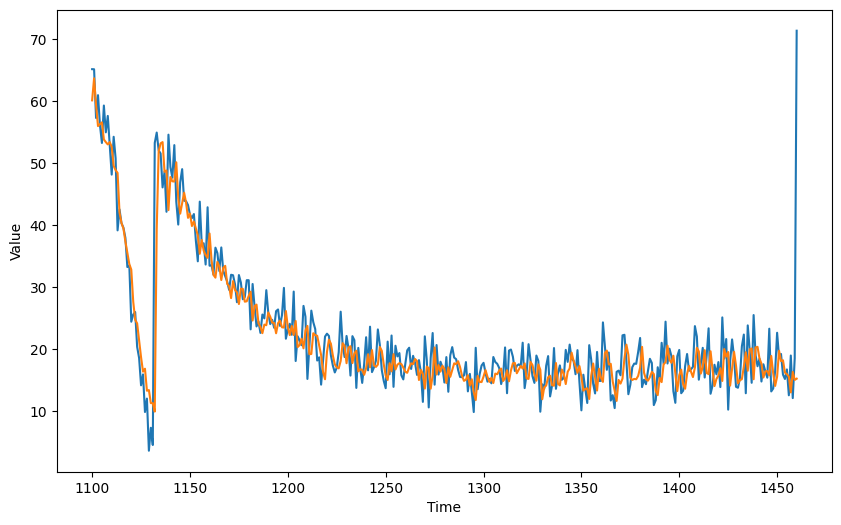

In [ ]:
forecast = []

for time in range(len(series) - window_size):
  forecast.append(model_ex_2.predict(series[time : time + window_size][np.newaxis]))

forecast = forecast[split_time - window_size :]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)

plot_series(time_valid, results)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

3.2887328

# § 04.03. RNNs for Time Series

## RNNs

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
  plt.figure(figsize=(10, 6))
  if type(series) is tuple:
    for series_num in series:
      plt.plot(time[start:end], series_num[start:end], format)

  else:
    plt.plot(time[start:end], series[start:end], format)
  plt.xlabel("Time")
  plt.ylabel("Value")
  plt.grid(True)
  plt.show()

def trend(time, slope=0):
  return slope * time

def seasonal_pattern(season_time):
  return np.where(season_time < 0.4,
                  np.cos(season_time * 2 * np.pi),
                  1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
  season_time = ((time + phase) % period) / period
  return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time)) * noise_level

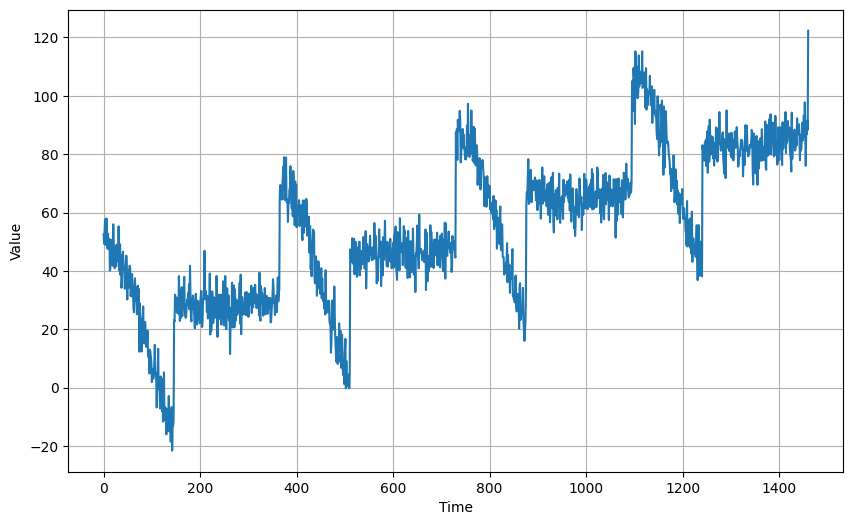

In [3]:
time = np.arange(4 * 365 + 1, dtype="float32")

intercept = 10
amplitude = 40
slope = 0.05

noise_level = 5

# Create the series
series = intercept + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update w/ noise
series += noise(time, noise_level, seed=42)

# Plot the results
plot_series(time, series)

In [4]:
split_time = 1_000

time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [5]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [6]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [7]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1_000

dataset = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

In [8]:
for window in dataset.take(1):
  print(f"Shape of feature: {window[0].shape}")
  print(f"Shape of label: {window[1].shape}")

Shape of feature: (128, 20)
Shape of label: (128,)


In [9]:
model_RNN = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[window_size]),
    tf.keras.layers.SimpleRNN(40, return_sequences=True),
    tf.keras.layers.SimpleRNN(40),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.)
])

model_RNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 20, 1)             0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 20, 40)            1680      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 40)                3240      
                                                                 
 dense (Dense)               (None, 1)                 41        
                                                                 
 lambda_1 (Lambda)           (None, 1)                 0         
                                                                 
Total params: 4961 (19.38 KB)
Trainable params: 4961 (19.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [10]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20)
)

optimizer = tf.keras.optimizers.SGD(momentum=0.9)

model_RNN.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer,
                  metrics=["mae"])

history_RNN = model_RNN.fit(dataset,
                            epochs=100,
                            callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 7s 102ms/step - loss: 167.8810 - mae: 168.3810 - lr: 1.0000e-08
Epoch 2/100
8/8 [==============================] - 1s 78ms/step - loss: 166.8019 - mae: 167.3019 - lr: 1.1220e-08
Epoch 3/100
8/8 [==============================] - 1s 56ms/step - loss: 165.0834 - mae: 165.5834 - lr: 1.2589e-08
Epoch 4/100
8/8 [==============================] - 0s 30ms/step - loss: 162.9524 - mae: 163.4524 - lr: 1.4125e-08
Epoch 5/100
8/8 [==============================] - 0s 48ms/step - loss: 160.4937 - mae: 160.9933 - lr: 1.5849e-08
Epoch 6/100
8/8 [==============================] - 1s 71ms/step - loss: 157.6883 - mae: 158.1883 - lr: 1.7783e-08
Epoch 7/100
8/8 [==============================] - 1s 58ms/step - loss: 154.5854 - mae: 155.0854 - lr: 1.9953e-08
Epoch 8/100
8/8 [==============================] - 0s 30ms/step - loss: 151.1008 - mae: 151.6008 - lr: 2.2387e-08
Epoch 9/100
8/8 [==============================] - 0s 33ms/step - loss: 147.1989 - mae:

(1e-08, 0.001, 0.0, 50.0)

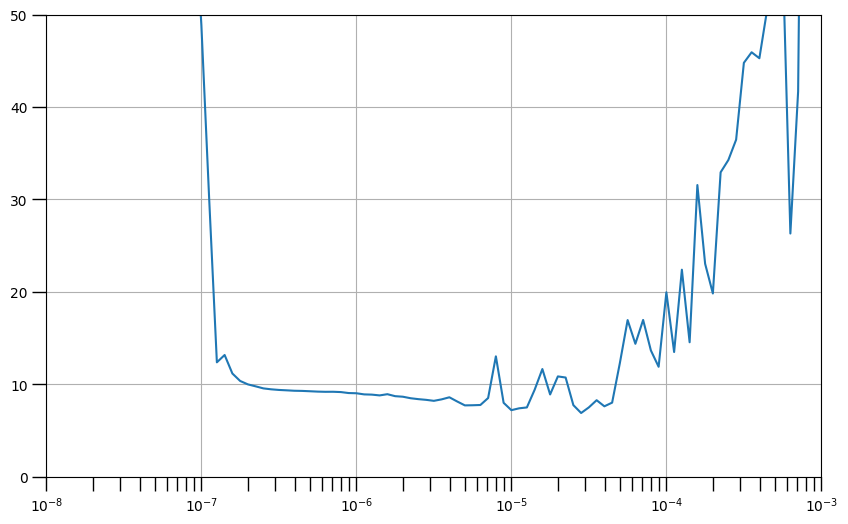

In [11]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

plt.figure(figsize=(10, 6))
plt.grid(True)

plt.semilogx(lrs, history_RNN.history["loss"])
plt.tick_params('both', length=10, width=1, which='both')
plt.axis([1e-8, 1e-3, 0, 50])

(1e-07, 0.0001, 0.0, 20.0)

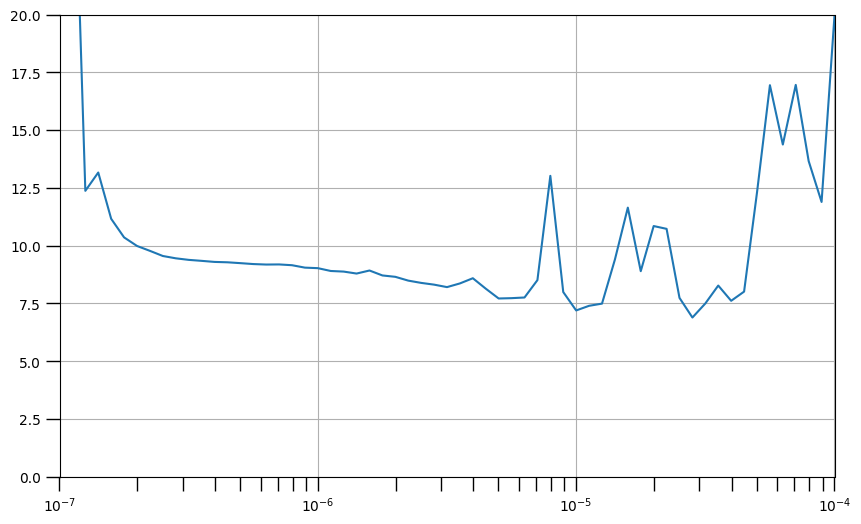

In [12]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

plt.figure(figsize=(10, 6))
plt.grid(True)

plt.semilogx(lrs, history_RNN.history["loss"])
plt.tick_params('both', length=10, width=1, which='both')
plt.axis([1e-7, 1e-4, 0, 20])

In [13]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [14]:
model_RNN = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[window_size]),
    tf.keras.layers.SimpleRNN(40, return_sequences=True),
    tf.keras.layers.SimpleRNN(40),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

learning_rate = 1e-6

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

model_RNN.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer,
                  metrics=["mae"])

history_RNNc = model_RNN.fit(dataset,
                             epochs=400)

Epoch 1/400
8/8 [==============================] - 3s 70ms/step - loss: 159.9947 - mae: 160.4947
Epoch 2/400
8/8 [==============================] - 1s 45ms/step - loss: 70.0717 - mae: 70.5717
Epoch 3/400
8/8 [==============================] - 0s 32ms/step - loss: 21.7810 - mae: 22.2772
Epoch 4/400
8/8 [==============================] - 0s 34ms/step - loss: 25.6257 - mae: 26.1210
Epoch 5/400
8/8 [==============================] - 0s 33ms/step - loss: 16.2712 - mae: 16.7645
Epoch 6/400
8/8 [==============================] - 0s 33ms/step - loss: 15.1669 - mae: 15.6580
Epoch 7/400
8/8 [==============================] - 0s 34ms/step - loss: 13.9389 - mae: 14.4315
Epoch 8/400
8/8 [==============================] - 0s 33ms/step - loss: 13.9255 - mae: 14.4193
Epoch 9/400
8/8 [==============================] - 0s 35ms/step - loss: 13.7355 - mae: 14.2270
Epoch 10/400
8/8 [==============================] - 0s 32ms/step - loss: 13.6692 - mae: 14.1578
Epoch 11/400
8/8 [=============================

1/1 [==============================] - 0s 18ms/step


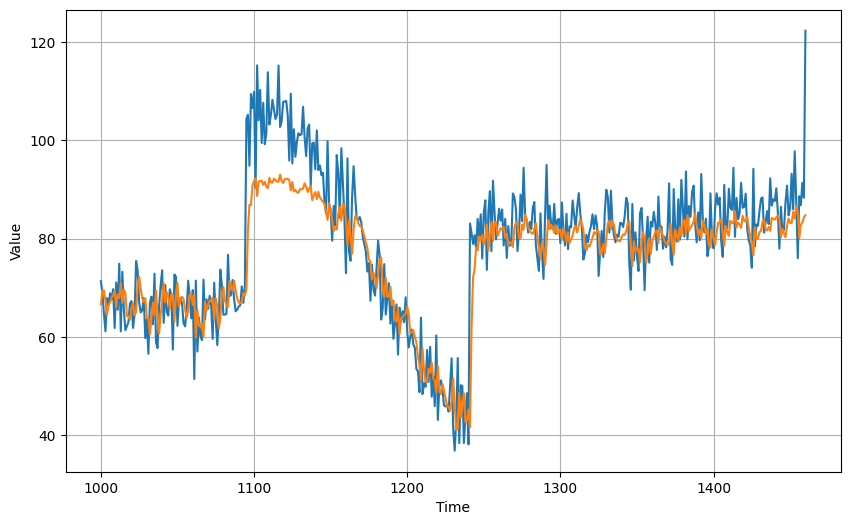

In [15]:
forecast = []

# Reduce the original series
forecast_series = series[split_time - window_size :]

for time in range(len(forecast_series) - window_size):
  forecast.append(model_RNN.predict(forecast_series[time : time + window_size][np.newaxis]))

# Drop single dimensional axis
results = np.array(forecast).squeeze()

plot_series(time_valid, (x_valid, results))

In [16]:
def model_forecast(model, series, window_size, batch_size):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda w: w.batch(window_size))
  dataset = dataset.batch(batch_size).prefetch(1)
  forecast = model.predict(dataset)

  return forecast

15/15 [==============================] - 0s 9ms/step


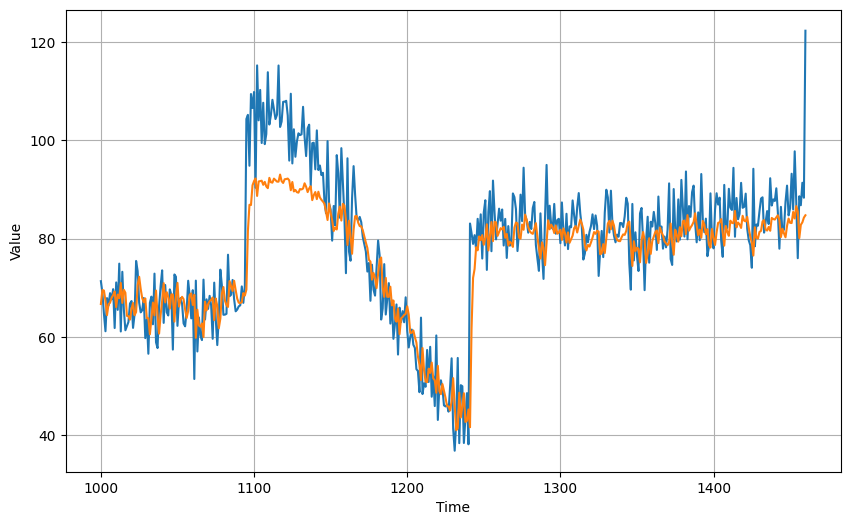

In [17]:
# Reduce the original series
forecast_series = series[split_time - window_size:-1]

forecast = model_forecast(model_RNN, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

plot_series(time_valid, (x_valid, results))

In [18]:
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

61.544765
5.7504773


In [19]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

<Figure size 640x480 with 0 Axes>

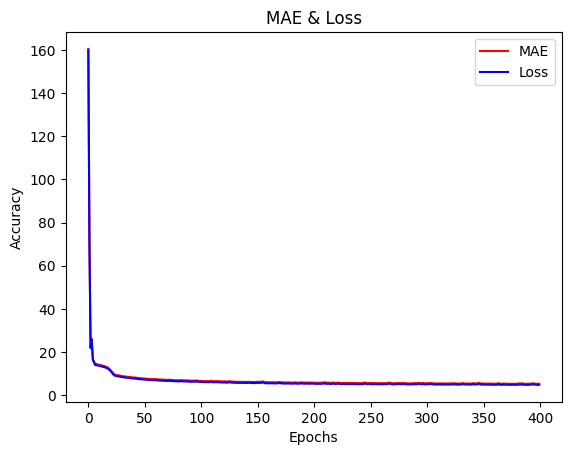

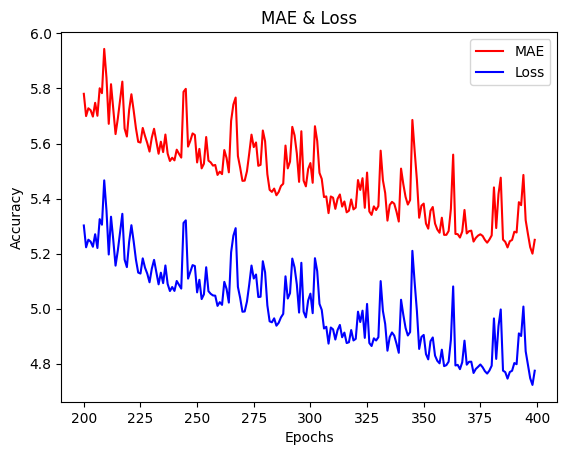

<Figure size 640x480 with 0 Axes>

In [20]:
# Retrieve a list of list results on training & test data sets for each training epoch
mae       = history_RNNc.history['mae']
loss      = history_RNNc.history['loss']

# Plot MAE & Loss per epoch
epochs = range(len(mae))

plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title("MAE & Loss")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

# Plot zoomed MAE & Loss per epoch
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title("MAE & Loss")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

## LSTMs

In [21]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [22]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1_000

dataset = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

In [23]:
model_LSTM = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[window_size]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

model_LSTM.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 20, 1)             0         
                                                                 
 bidirectional (Bidirection  (None, 20, 64)            8704      
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                24832     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
 lambda_1 (Lambda)           (None, 1)                 0         
                                                                 
Total params: 33601 (131.25 KB)
Trainable params: 33601 

In [24]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20)
)

optimizer = tf.keras.optimizers.SGD(momentum=0.9)

model_LSTM.compile(loss=tf.keras.losses.Huber(),
                   optimizer=optimizer,
                   metrics=["mae"])

history_LSTM = model_LSTM.fit(dataset,
                              epochs=100,
                              callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 6s 15ms/step - loss: 65.0126 - mae: 65.5126 - lr: 1.0000e-08
Epoch 2/100
8/8 [==============================] - 0s 10ms/step - loss: 64.6715 - mae: 65.1715 - lr: 1.1220e-08
Epoch 3/100
8/8 [==============================] - 0s 10ms/step - loss: 64.2415 - mae: 64.7415 - lr: 1.2589e-08
Epoch 4/100
8/8 [==============================] - 0s 10ms/step - loss: 63.8106 - mae: 64.3106 - lr: 1.4125e-08
Epoch 5/100
8/8 [==============================] - 0s 10ms/step - loss: 63.3859 - mae: 63.8859 - lr: 1.5849e-08
Epoch 6/100
8/8 [==============================] - 0s 10ms/step - loss: 62.9512 - mae: 63.4512 - lr: 1.7783e-08
Epoch 7/100
8/8 [==============================] - 0s 10ms/step - loss: 62.4902 - mae: 62.9902 - lr: 1.9953e-08
Epoch 8/100
8/8 [==============================] - 0s 10ms/step - loss: 61.9949 - mae: 62.4947 - lr: 2.2387e-08
Epoch 9/100
8/8 [==============================] - 0s 9ms/step - loss: 61.4523 - mae: 61.9518 - lr: 2.51

(1e-08, 0.001, 0.0, 30.0)

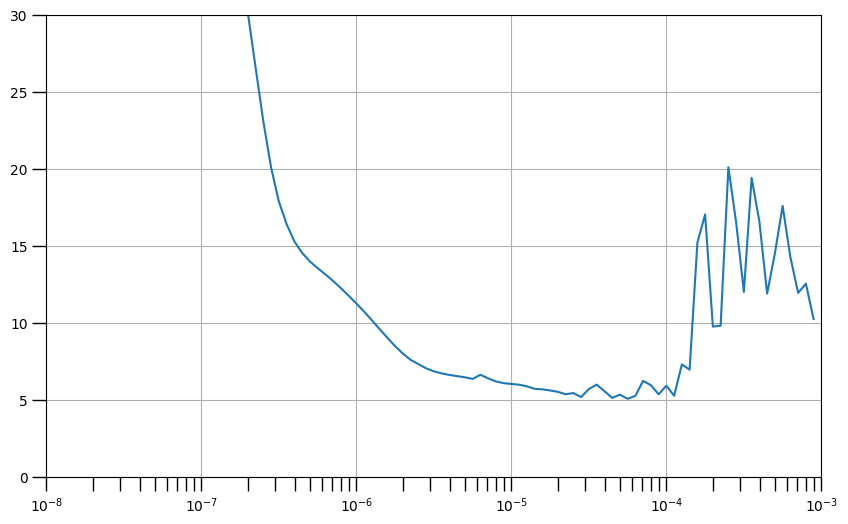

In [25]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

plt.figure(figsize=(10, 6))
plt.grid(True)

plt.semilogx(lrs, history_LSTM.history["loss"])
plt.tick_params('both', length=10, width=1, which='both')
plt.axis([1e-8, 1e-3, 0, 30])

In [26]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [27]:
model_LSTM = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# lr_schedule = tf.keras.callbacks.LearningRateScheduler(
#     lambda epoch: 1e-8 * 10**(epoch / 20)
# )

learning_rate = 2e-6

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

model_LSTM.compile(loss=tf.keras.losses.Huber(),
                   optimizer=optimizer,
                   metrics=["mae"])

history_LSTMc = model_LSTM.fit(dataset,
                               epochs=500,
                               # callbacks=[lr_schedule],
                               verbose=0)

In [28]:
def model_forecast(model, series, window_size, batch_size):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda w: w.batch(window_size))
  dataset = dataset.batch(batch_size).prefetch(1)
  forecast = model.predict(dataset)

  return forecast

15/15 [==============================] - 1s 6ms/step


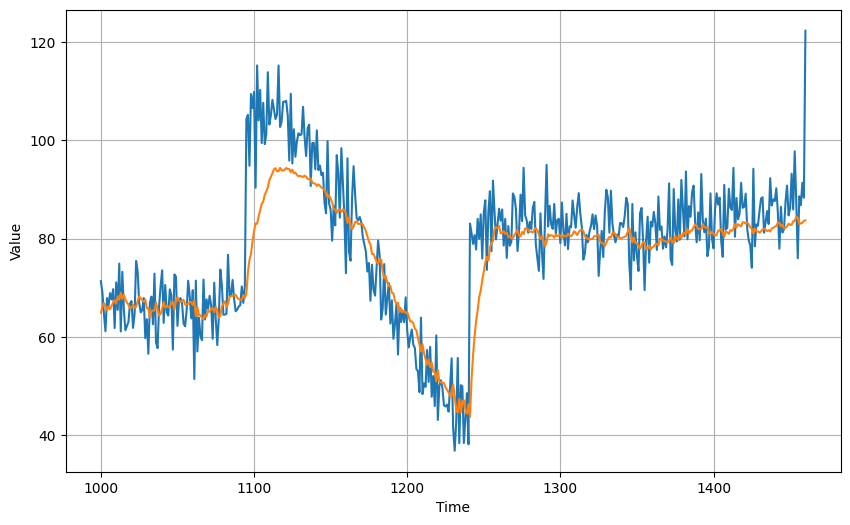

In [29]:
# Reduce the original series
forecast_series = series[split_time - window_size:-1]

forecast = model_forecast(model_LSTM, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

plot_series(time_valid, (x_valid, results))

In [30]:
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

67.784836
5.891213


In [31]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

<Figure size 640x480 with 0 Axes>

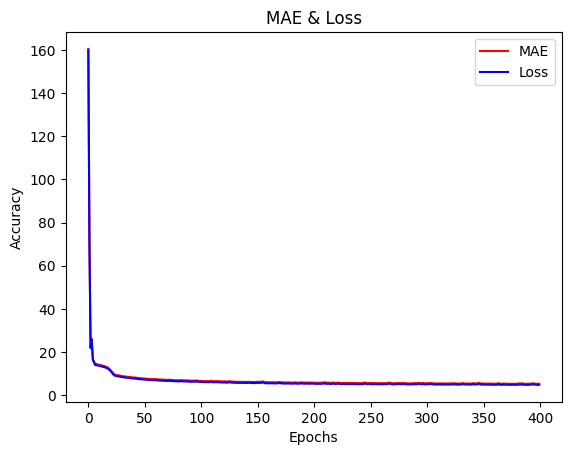

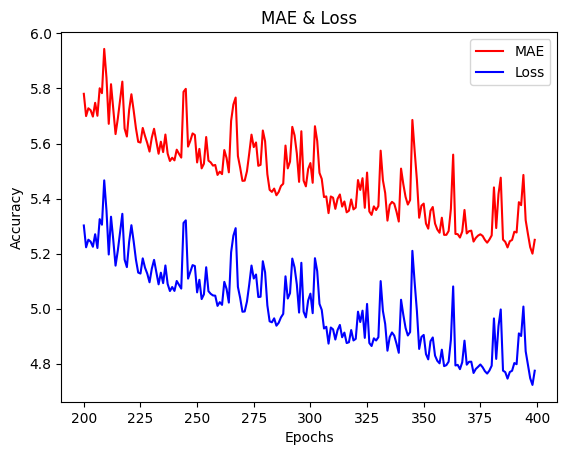

<Figure size 640x480 with 0 Axes>

In [32]:
# Retrieve a list of list results on training & test data sets for each training epoch
mae       = history_RNNc.history['mae']
loss      = history_RNNc.history['loss']

# Plot MAE & Loss per epoch
epochs = range(len(mae))

plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title("MAE & Loss")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

# Plot zoomed MAE & Loss per epoch
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title("MAE & Loss")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

In [33]:
# Generate data windows of the validation set
val_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)

In [34]:
model_LSTM = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

learning_rate = 2e-6

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model_LSTM.compile(loss=tf.keras.losses.Huber(),
                   optimizer=optimizer,
                   metrics=["mae"])

# Train the model
history_LSTMv = model_LSTM.fit(dataset,
                               epochs=100,
                               validation_data=val_set)

Epoch 1/100
8/8 [==============================] - 7s 212ms/step - loss: 29.3894 - mae: 29.8851 - val_loss: 49.5582 - val_mae: 50.0565
Epoch 2/100
8/8 [==============================] - 0s 23ms/step - loss: 20.0400 - mae: 20.5377 - val_loss: 46.7934 - val_mae: 47.2934
Epoch 3/100
8/8 [==============================] - 0s 24ms/step - loss: 16.9008 - mae: 17.3959 - val_loss: 31.8023 - val_mae: 32.3003
Epoch 4/100
8/8 [==============================] - 0s 26ms/step - loss: 14.9058 - mae: 15.3979 - val_loss: 24.3847 - val_mae: 24.8833
Epoch 5/100
8/8 [==============================] - 0s 24ms/step - loss: 13.2254 - mae: 13.7175 - val_loss: 26.4212 - val_mae: 26.9195
Epoch 6/100
8/8 [==============================] - 0s 24ms/step - loss: 11.5425 - mae: 12.0330 - val_loss: 22.6715 - val_mae: 23.1699
Epoch 7/100
8/8 [==============================] - 0s 24ms/step - loss: 9.9554 - mae: 10.4436 - val_loss: 19.7203 - val_mae: 20.2182
Epoch 8/100
8/8 [==============================] - 0s 25ms/ste

## Ex. 3) Prediction using LSTM

In [42]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [43]:
import numpy as np
import matplotlib.pyplot as plt

In [44]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """An arbitrary pattern"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi),
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

In [45]:
time = np.arange(10 * 365 + 1, dtype="float32")

intercept = 10
amplitude = 50
slope = 0.005

noise_level = 3

# Create the series
series = intercept + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update w/ noise
series += noise(time, noise_level, seed=51)

In [46]:
split_time = 1_100

time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

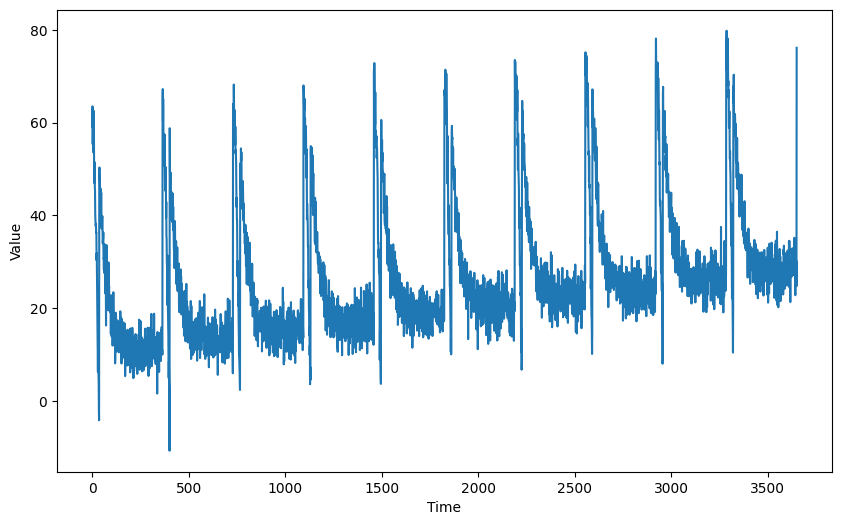

In [47]:
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [48]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer)
  dataset = dataset.map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)

  return dataset

In [49]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1_000

train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [50]:
model_ex_3 = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x + 100.)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 20)
)

lr=1e-8

optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9)

model_ex_3.compile(loss=tf.keras.losses.Huber(),
                   optimizer=optimizer,
                   metrics=["mae"])

history_ex_3 = model_ex_3.fit(train_set,
                              epochs=100,
                              callbacks=[lr_schedule])

Epoch 1/100
34/34 [==============================] - 7s 16ms/step - loss: 80.3271 - mae: 80.8271 - lr: 1.0000e-06
Epoch 2/100
34/34 [==============================] - 0s 10ms/step - loss: 80.3167 - mae: 80.8167 - lr: 1.1220e-06
Epoch 3/100
34/34 [==============================] - 0s 10ms/step - loss: 80.3044 - mae: 80.8044 - lr: 1.2589e-06
Epoch 4/100
34/34 [==============================] - 0s 9ms/step - loss: 80.2906 - mae: 80.7906 - lr: 1.4125e-06
Epoch 5/100
34/34 [==============================] - 0s 10ms/step - loss: 80.2751 - mae: 80.7751 - lr: 1.5849e-06
Epoch 6/100
34/34 [==============================] - 0s 9ms/step - loss: 80.2578 - mae: 80.7578 - lr: 1.7783e-06
Epoch 7/100
34/34 [==============================] - 0s 9ms/step - loss: 80.2383 - mae: 80.7383 - lr: 1.9953e-06
Epoch 8/100
34/34 [==============================] - 0s 9ms/step - loss: 80.2165 - mae: 80.7165 - lr: 2.2387e-06
Epoch 9/100
34/34 [==============================] - 0s 9ms/step - loss: 80.1920 - mae: 80.6

(1e-06, 1.0, 0.0, 30.0)

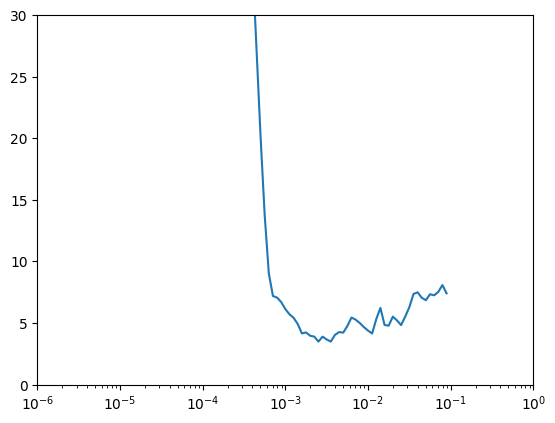

In [53]:
plt.semilogx(history_ex_3.history["lr"], history_ex_3.history["loss"])
plt.axis([1e-6, 1, 0, 30])

In [56]:
tf.keras.backend.clear_session()
# tf.random.set_seed(42)
# np.random.seed(42)

tf.random.set_seed(51)

In [57]:
model_ex_3 = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x + 100.)
])

lr = 1e-2

optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9)

model_ex_3.compile(loss=tf.keras.losses.Huber(),
                   optimizer=optimizer,
                   metrics=["mae"])

history_ex_3c = model_ex_3.fit(train_set,
                               epochs=50,
                               verbose=1)

Epoch 1/50
34/34 [==============================] - 7s 11ms/step - loss: 54.3253 - mae: 54.8246
Epoch 2/50
34/34 [==============================] - 0s 9ms/step - loss: 9.1675 - mae: 9.6517
Epoch 3/50
34/34 [==============================] - 0s 9ms/step - loss: 7.2119 - mae: 7.6898
Epoch 4/50
34/34 [==============================] - 0s 10ms/step - loss: 7.1357 - mae: 7.6084
Epoch 5/50
34/34 [==============================] - 0s 9ms/step - loss: 7.1564 - mae: 7.6354
Epoch 6/50
34/34 [==============================] - 0s 10ms/step - loss: 6.7858 - mae: 7.2593
Epoch 7/50
34/34 [==============================] - 0s 9ms/step - loss: 6.0677 - mae: 6.5379
Epoch 8/50
34/34 [==============================] - 0s 9ms/step - loss: 5.3259 - mae: 5.7948
Epoch 9/50
34/34 [==============================] - 0s 9ms/step - loss: 5.1950 - mae: 5.6630
Epoch 10/50
34/34 [==============================] - 0s 9ms/step - loss: 4.6600 - mae: 5.1271
Epoch 11/50
34/34 [==============================] - 0s 9ms/step

In [58]:
forecast = []
results = []
for time in range(len(series) - window_size):
  forecast.append(model_ex_3.predict(series[time : time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

1/1 [==============================] - 0s 40ms/step


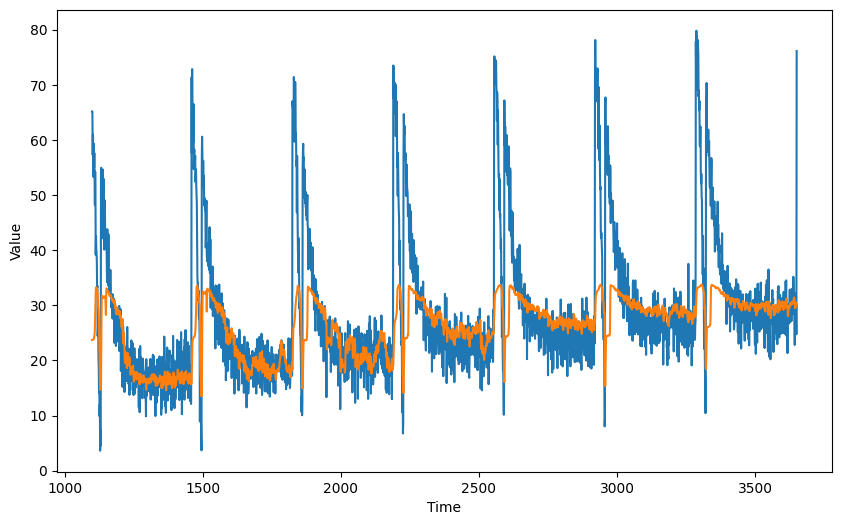

In [59]:
plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [60]:
# print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

6.479844


# § 04.04. Real-world Time Series Data

## Synthetic Data w/ Conv1D, and LSTM

In [1]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def plot_series(x, y, format="-", start=0, end=None,
                title=None, xlabel=None, ylabel=None, legend=None):
  plt.figure(figsize=(10, 6))
  if type(y) is tuple:
    for y_curr in y:
      plt.plot(x[start:end], y_curr[start:end], format)
  else:
    plt.plot(x[start:end], y[start:end], format)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  if legend:
    plt.legend(legend)
  plt.title(title)
  plt.grid(True)
  plt.show()

def trend(time, slope=0):
  return slope * time

def trend(time, slope=0):
  return slope * time

def seasonal_pattern(season_time):
  return np.where(season_time < 0.4,
                  np.cos(season_time * 2 * np.pi),
                  1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
  season_time = ((time + phase) % period) / period
  return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time)) * noise_level

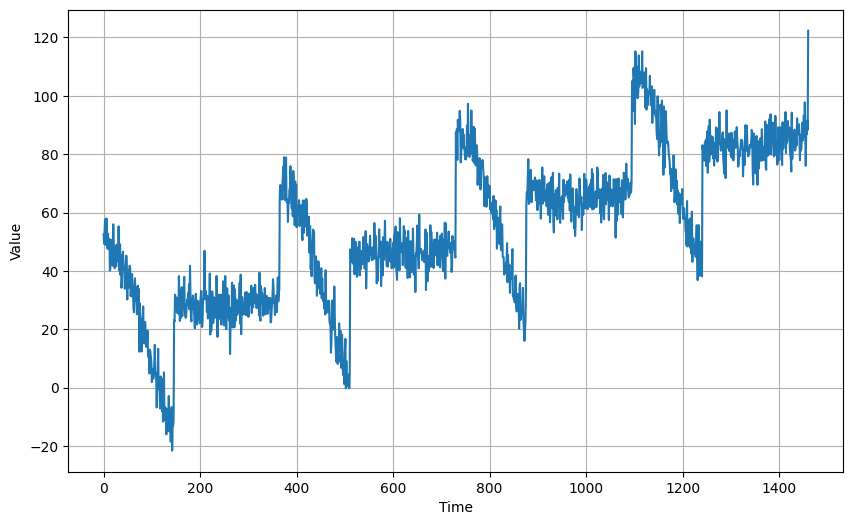

In [4]:
time = np.arange(4 * 365 + 1, dtype="float32")

intercept = 10
amplitude = 40
slope = 0.05

noise_level = 5

# Create the series
series = intercept + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update w/ noise
series += noise(time, noise_level, seed=42)

# Plot the results
plot_series(time, series, xlabel="Time", ylabel="Value")

In [5]:
split_time = 1_000

time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer): # !!
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.map(lambda w: (w[:-1], w[-1]))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.batch(batch_size).prefetch(1)

  return ds

In [7]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [8]:
window_size = 20
batch_size = 16
shuffle_buffer_size = 1_000

train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [9]:
model_Conv1D_LSTM = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, strides=1, padding="causal",
                           activation="relu", input_shape=[window_size, 1]),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])

model_Conv1D_LSTM.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 20, 64)            256       
                                                                 
 lstm (LSTM)                 (None, 20, 64)            33024     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
 lambda (Lambda)             (None, 1)                 0         
                                                                 
Total params: 66369 (259.25 KB)
Trainable params: 66369 (259.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [10]:
init_weights = model_Conv1D_LSTM.get_weights()

In [11]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20)
)

optimizer = tf.keras.optimizers.SGD(momentum=0.9)

model_Conv1D_LSTM.compile(loss=tf.keras.losses.Huber(),
                          optimizer=optimizer)

history_Conv1D_LSTM = model_Conv1D_LSTM.fit(train_set,
                                            epochs=100,
                                            callbacks=[lr_schedule])

Epoch 1/100
62/62 [==============================] - 19s 48ms/step - loss: 166.2588 - lr: 1.0000e-08
Epoch 2/100
62/62 [==============================] - 4s 61ms/step - loss: 107.7701 - lr: 1.1220e-08
Epoch 3/100
62/62 [==============================] - 3s 45ms/step - loss: 47.3912 - lr: 1.2589e-08
Epoch 4/100
62/62 [==============================] - 3s 45ms/step - loss: 13.4534 - lr: 1.4125e-08
Epoch 5/100
62/62 [==============================] - 2s 30ms/step - loss: 12.3789 - lr: 1.5849e-08
Epoch 6/100
62/62 [==============================] - 1s 22ms/step - loss: 11.9062 - lr: 1.7783e-08
Epoch 7/100
62/62 [==============================] - 2s 23ms/step - loss: 11.4158 - lr: 1.9953e-08
Epoch 8/100
62/62 [==============================] - 2s 24ms/step - loss: 10.9823 - lr: 2.2387e-08
Epoch 9/100
62/62 [==============================] - 2s 23ms/step - loss: 10.4901 - lr: 2.5119e-08
Epoch 10/100
62/62 [==============================] - 2s 34ms/step - loss: 10.0085 - lr: 2.8184e-08
Epoch 

(1e-08, 0.001, 0.0, 50.0)

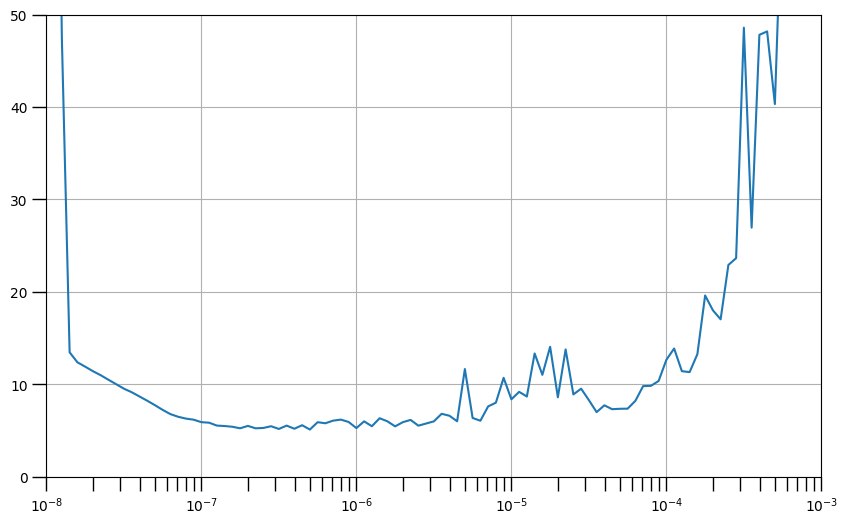

In [12]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

plt.figure(figsize=(10, 6))
plt.grid(True)

plt.semilogx(lrs, history_Conv1D_LSTM.history["loss"])
plt.tick_params("both", length=10, width=1, which="both")
plt.axis([1e-8, 1e-3, 0, 50])

In [13]:
tf.keras.backend.clear_session()
# tf.random.set_seed(42)
# np.random.seed(42)

In [14]:
model_Conv1D_LSTM.set_weights(init_weights)

In [15]:
# lr_schedule = tf.keras.callbacks.LearningRateScheduler(
#     lambda epoch: 1e-8 * 10**(epoch / 20)
# )

learning_rate = 1e-7

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

model_Conv1D_LSTM.compile(loss=tf.keras.losses.Huber(),
                          optimizer=optimizer,
                          metrics=["mae"])

history_Conv1D_LSTMc = model_Conv1D_LSTM.fit(train_set,
                                             epochs=500)

Epoch 1/500
62/62 [==============================] - 14s 44ms/step - loss: 64.1230 - mae: 64.6182
Epoch 2/500
62/62 [==============================] - 2s 36ms/step - loss: 11.6965 - mae: 12.1817
Epoch 3/500
62/62 [==============================] - 3s 41ms/step - loss: 9.6294 - mae: 10.1149
Epoch 4/500
62/62 [==============================] - 3s 44ms/step - loss: 8.2444 - mae: 8.7245
Epoch 5/500
62/62 [==============================] - 3s 39ms/step - loss: 7.1966 - mae: 7.6804
Epoch 6/500
62/62 [==============================] - 2s 31ms/step - loss: 6.4021 - mae: 6.8774
Epoch 7/500
62/62 [==============================] - 4s 55ms/step - loss: 6.1365 - mae: 6.6113
Epoch 8/500
62/62 [==============================] - 3s 37ms/step - loss: 5.9523 - mae: 6.4307
Epoch 9/500
62/62 [==============================] - 3s 41ms/step - loss: 5.9566 - mae: 6.4365
Epoch 10/500
62/62 [==============================] - 3s 44ms/step - loss: 5.5923 - mae: 6.0690
Epoch 11/500
62/62 [=======================

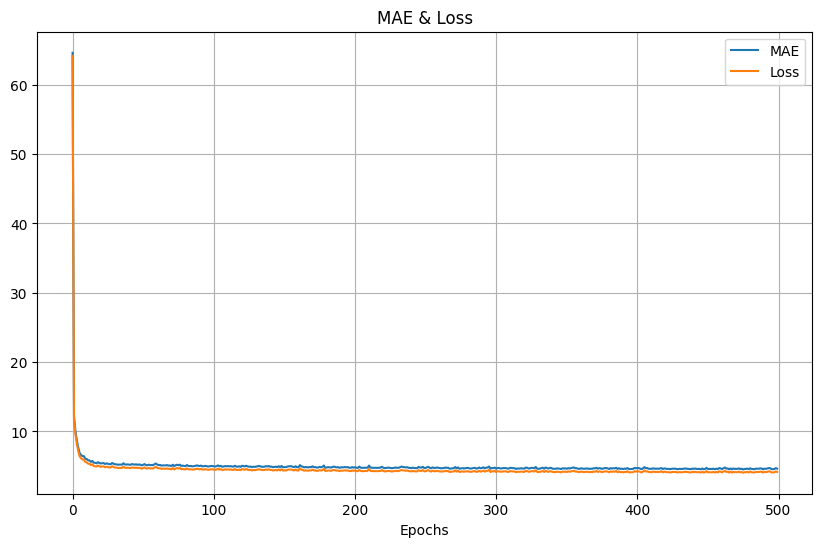

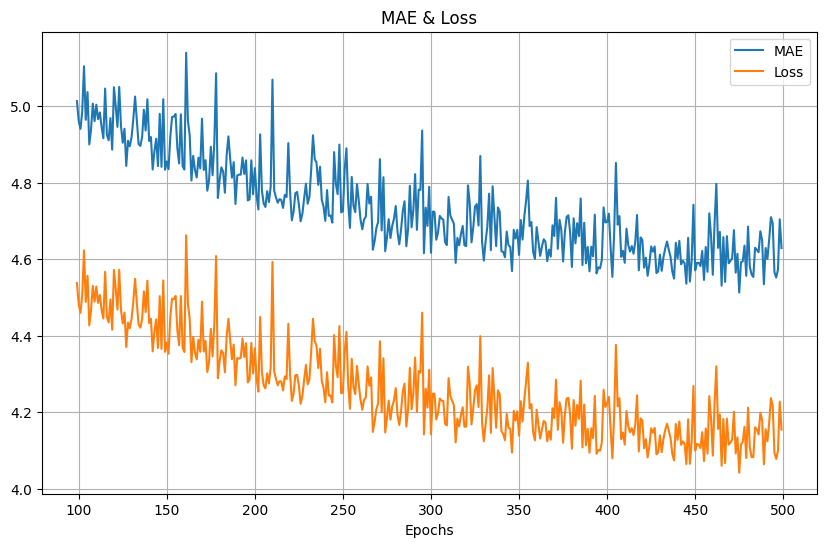

In [16]:
# Retrieve a list of list results on training & test data sets for each training epoch
mae       = history_Conv1D_LSTMc.history['mae']
loss      = history_Conv1D_LSTMc.history['loss']

# Plot MAE & Loss per epoch
epochs = range(len(loss))

plot_series(x=epochs, y=(mae, loss),
            title="MAE & Loss", xlabel="Epochs", legend=["MAE", "Loss"])

# Only plot the last 80% epochs
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed MAE & Loss per epoch
plot_series(x=epochs_zoom, y=(mae_zoom, loss_zoom),
            title="MAE & Loss", xlabel="Epochs", legend=["MAE", "Loss"])

In [17]:
def model_forecast(model, series, window_size, batch_size):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda w: w.batch(window_size))
  dataset = dataset.batch(batch_size).prefetch(1)
  forecast = model.predict(dataset)

  return forecast

29/29 [==============================] - 1s 9ms/step


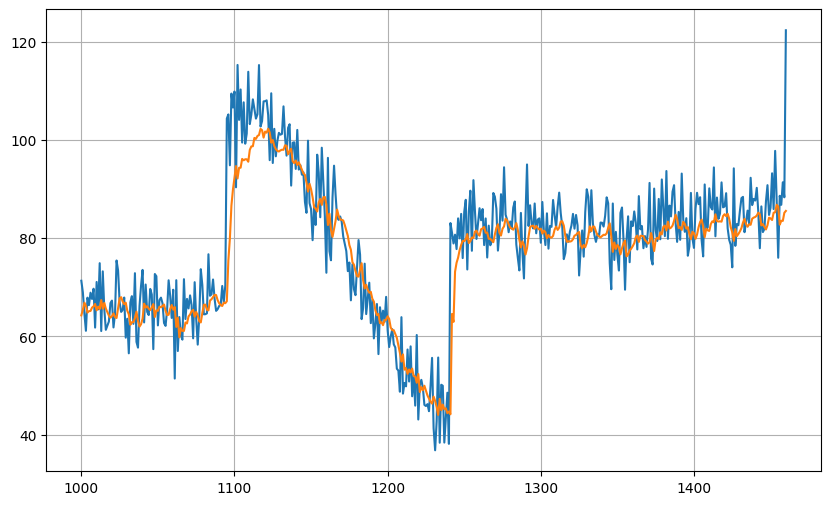

In [18]:
forecast_series = series[split_time-window_size : -1]
forecast = model_forecast(model_Conv1D_LSTM, forecast_series, window_size, batch_size)

results = forecast.squeeze()

plot_series(time_valid, (x_valid, results))

In [19]:
# print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

5.0595646


In [20]:
val_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)

In [21]:
# model_Conv1D_LSTM.set_weights(init_weights)

In [22]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get("val_mae") < 5.2):
      print("\nRequired Validation MAE is met so cancelling training!")
      self.model.stop_training = True

In [23]:
callbacks = myCallback()

In [24]:
learning_rate = 4e-8

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

model_Conv1D_LSTM.compile(loss=tf.keras.losses.Huber(),
                          optimizer=optimizer,
                          metrics=["mae"])

history_Conv1D_LSTMcC = model_Conv1D_LSTM.fit(train_set,
                                              epochs=500,
                                              validation_data=val_set,
                                              callbacks=[callbacks])

Epoch 1/500
     60/Unknown - 6s 23ms/step - loss: 4.0356 - mae: 4.5070
Required Validation MAE is met so cancelling training!
62/62 [==============================] - 8s 50ms/step - loss: 4.0398 - mae: 4.5113 - val_loss: 4.4628 - val_mae: 4.9385


29/29 [==============================] - 1s 10ms/step


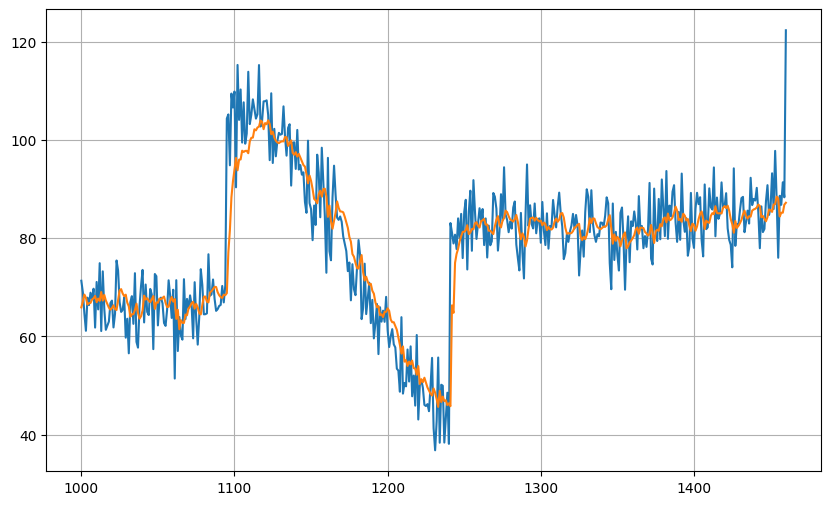

In [25]:
forecast_series = series[split_time-window_size : -1]
forecast = model_forecast(model_Conv1D_LSTM, forecast_series, window_size, batch_size)

results = forecast.squeeze()

plot_series(time_valid, (x_valid, results))

In [26]:
# print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

4.8881645


## Sunspots Prediction w/ DNN only

In [1]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def plot_series(x, y, format="-", start=0, end=None,
                title=None, xlabel=None, ylabel=None, legend=None):
  plt.figure(figsize=(10, 6))
  if type(y) is tuple:
    for y_curr in y:
      plt.plot(x[start:end], y_curr[start:end], format)
  else:
    plt.plot(x[start:end], y[start:end], format)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  if legend:
    plt.legend(legend)
  plt.title(title)
  plt.grid(True)
  plt.show()

In [4]:
!wget "https://storage.googleapis.com/tensorflow-1-public/course4/Sunspots.csv"

--2024-01-28 13:49:10--  https://storage.googleapis.com/tensorflow-1-public/course4/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.193.207, 172.217.204.207, 172.253.123.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.193.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [text/csv]
Saving to: ‘Sunspots.csv’

Sunspots.csv        100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2024-01-28 13:49:11 (47.7 MB/s) - ‘Sunspots.csv’ saved [70827/70827]



In [5]:
import csv

In [6]:
!head Sunspots.csv

,Date,Monthly Mean Total Sunspot Number
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7
5,1749-06-30,139.2
6,1749-07-31,158.0
7,1749-08-31,110.5
8,1749-09-30,126.5


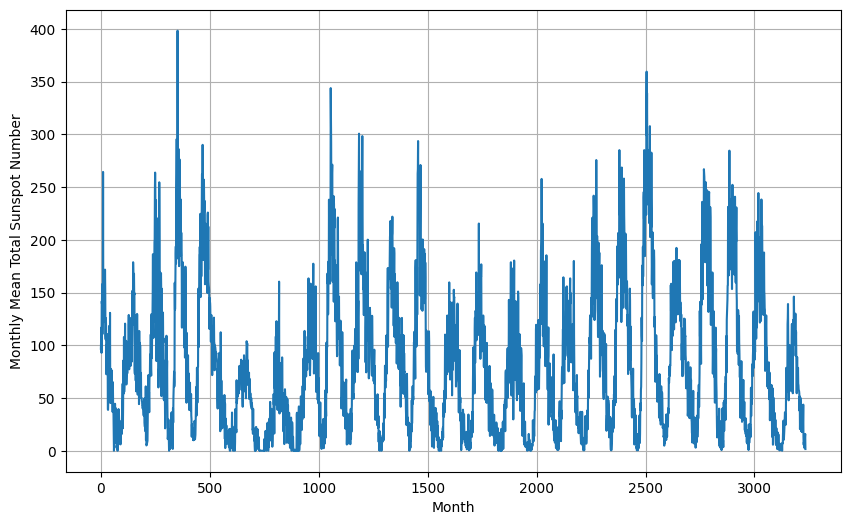

In [7]:
time_step = []
sunspots = []

with open('./Sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    time_step.append(int(row[0]))
    sunspots.append(float(row[2]))

time = np.array(time_step)
series = np.array(sunspots)

plot_series(time, series, xlabel="Month", ylabel="Monthly Mean Total Sunspot Number")

In [8]:
split_time = 3_000

time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [9]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.shuffle(shuffle_buffer)
  dataset = dataset.batch(batch_size).prefetch(1)

  return dataset

In [10]:
window_size = 30
batch_size = 32
shuffle_buffer_size = 1_000

train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [11]:
model_sDNN = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, activation="relu", input_shape=[window_size]),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

model_sDNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                930       
                                                                 
 dense_1 (Dense)             (None, 10)                310       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1251 (4.89 KB)
Trainable params: 1251 (4.89 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20)
)

optimizer = tf.keras.optimizers.SGD(momentum=0.9)

model_sDNN.compile(loss=tf.keras.losses.Huber(),
                   optimizer=optimizer)

history_sDNN = model_sDNN.fit(train_set,
                              epochs=100,
                              callbacks=[lr_schedule])

Epoch 1/100
93/93 [==============================] - 4s 20ms/step - loss: 96.1210 - lr: 1.0000e-08
Epoch 2/100
93/93 [==============================] - 1s 9ms/step - loss: 94.4769 - lr: 1.1220e-08
Epoch 3/100
93/93 [==============================] - 1s 10ms/step - loss: 92.6381 - lr: 1.2589e-08
Epoch 4/100
93/93 [==============================] - 1s 9ms/step - loss: 90.6047 - lr: 1.4125e-08
Epoch 5/100
93/93 [==============================] - 1s 11ms/step - loss: 88.3813 - lr: 1.5849e-08
Epoch 6/100
93/93 [==============================] - 1s 8ms/step - loss: 85.9394 - lr: 1.7783e-08
Epoch 7/100
93/93 [==============================] - 1s 4ms/step - loss: 83.2761 - lr: 1.9953e-08
Epoch 8/100
93/93 [==============================] - 1s 4ms/step - loss: 80.3745 - lr: 2.2387e-08
Epoch 9/100
93/93 [==============================] - 1s 5ms/step - loss: 77.2068 - lr: 2.5119e-08
Epoch 10/100
93/93 [==============================] - 1s 4ms/step - loss: 73.7629 - lr: 2.8184e-08
Epoch 11/100
93/

(1e-08, 0.001, 0.0, 100.0)

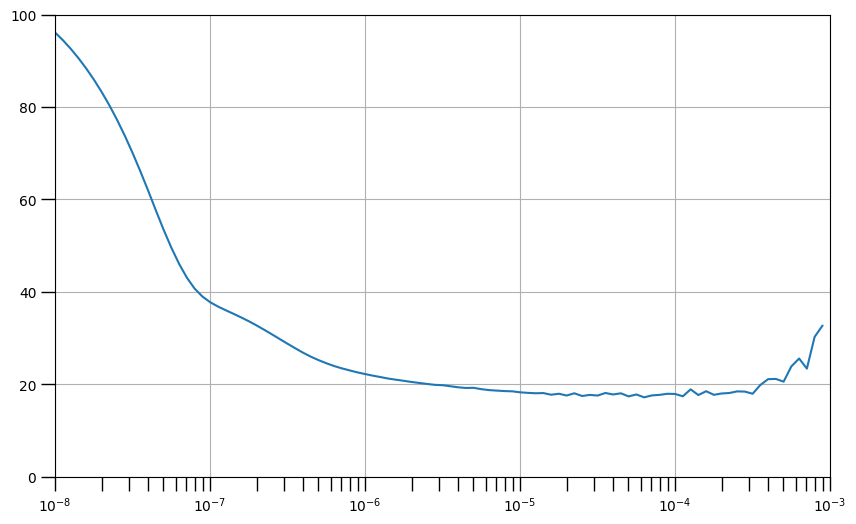

In [13]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

plt.figure(figsize=(10, 6))
plt.grid(True)

plt.semilogx(lrs, history_sDNN.history["loss"])
plt.tick_params("both", length=10, width=1, which="both")
plt.axis([1e-8, 1e-3, 0, 100])

In [14]:
tf.keras.backend.clear_session()
# tf.random.set_seed(42)
# np.random.seed(42)

In [15]:
# lr_schedule = tf.keras.callbacks.LearningRateScheduler(
#     lambda epoch: 1e-8 * 10**(epoch / 20)
# )

lr = 2e-5

optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9)

model_sDNN.compile(loss=tf.keras.losses.Huber(),
                   optimizer=optimizer,
                   metrics=["mae"])

history_sDNNc = model_sDNN.fit(train_set,
                               epochs=100)
                               # callbacks=[lr_schedule])

Epoch 1/100
93/93 [==============================] - 1s 5ms/step - loss: 17.7018 - mae: 18.1957
Epoch 2/100
93/93 [==============================] - 1s 5ms/step - loss: 17.3912 - mae: 17.8849
Epoch 3/100
93/93 [==============================] - 1s 4ms/step - loss: 17.3486 - mae: 17.8422
Epoch 4/100
93/93 [==============================] - 1s 4ms/step - loss: 17.3504 - mae: 17.8435
Epoch 5/100
93/93 [==============================] - 1s 4ms/step - loss: 17.4678 - mae: 17.9610
Epoch 6/100
93/93 [==============================] - 1s 4ms/step - loss: 17.3199 - mae: 17.8123
Epoch 7/100
93/93 [==============================] - 1s 4ms/step - loss: 17.3711 - mae: 17.8631
Epoch 8/100
93/93 [==============================] - 1s 4ms/step - loss: 17.2922 - mae: 17.7837
Epoch 9/100
93/93 [==============================] - 1s 4ms/step - loss: 17.1325 - mae: 17.6253
Epoch 10/100
93/93 [==============================] - 1s 4ms/step - loss: 17.1342 - mae: 17.6267
Epoch 11/100
93/93 [===================

In [16]:
def model_forecast(model, series, window_size, batch_size):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda w: w.batch(window_size))
  dataset = dataset.batch(batch_size).prefetch(1)
  forecast = model.predict(dataset)

  return forecast

8/8 [==============================] - 0s 6ms/step


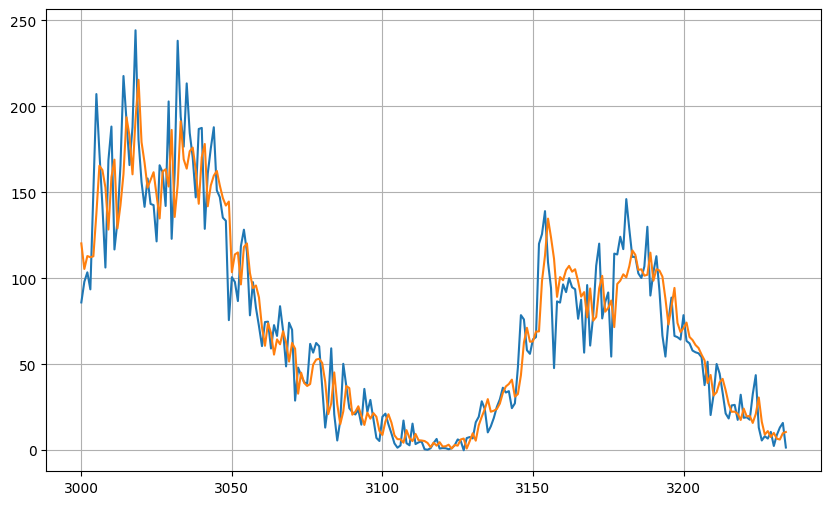

In [17]:
forecast_series = series[split_time-window_size : -1]
forecast = model_forecast(model_sDNN, forecast_series, window_size, batch_size)

results = forecast.squeeze()

plot_series(time_valid, (x_valid, results))

In [18]:
# print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

14.632463


## Sunspots Prediction w/ Conv1D, LSTM, and DNN

In [19]:
model_s3 = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, strides=1, padding="causal",
                           activation="relu", input_shape=[window_size, 1]),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])

model_s3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 30, 64)            256       
                                                                 
 lstm (LSTM)                 (None, 30, 64)            33024     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 30)                1950      
                                                                 
 dense_1 (Dense)             (None, 10)                310       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
 lambda (Lambda)             (None, 1)                 0

In [20]:
# Get initial weights
init_weights = model_s3.get_weights()

In [21]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20)
)

optimizer = tf.keras.optimizers.SGD(momentum=0.9)

model_s3.compile(loss=tf.keras.losses.Huber(),
                 optimizer=optimizer)

history_s3 = model_s3.fit(train_set,
                          epochs=100,
                          callbacks=[lr_schedule])

Epoch 1/100
93/93 [==============================] - 8s 38ms/step - loss: 50.1048 - lr: 1.0000e-08
Epoch 2/100
93/93 [==============================] - 4s 37ms/step - loss: 42.1799 - lr: 1.1220e-08
Epoch 3/100
93/93 [==============================] - 5s 49ms/step - loss: 38.6796 - lr: 1.2589e-08
Epoch 4/100
93/93 [==============================] - 4s 37ms/step - loss: 36.9817 - lr: 1.4125e-08
Epoch 5/100
93/93 [==============================] - 4s 37ms/step - loss: 36.0086 - lr: 1.5849e-08
Epoch 6/100
93/93 [==============================] - 5s 49ms/step - loss: 35.3160 - lr: 1.7783e-08
Epoch 7/100
93/93 [==============================] - 4s 37ms/step - loss: 34.6920 - lr: 1.9953e-08
Epoch 8/100
93/93 [==============================] - 4s 45ms/step - loss: 34.0507 - lr: 2.2387e-08
Epoch 9/100
93/93 [==============================] - 4s 45ms/step - loss: 33.3352 - lr: 2.5119e-08
Epoch 10/100
93/93 [==============================] - 4s 37ms/step - loss: 32.4550 - lr: 2.8184e-08
Epoch 11/

(1e-08, 0.001, 0.0, 100.0)

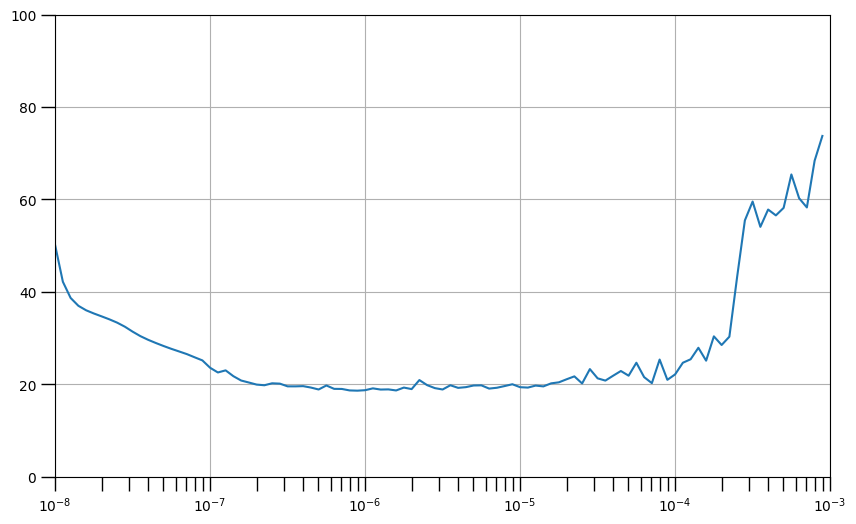

In [22]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

plt.figure(figsize=(10, 6))
plt.grid(True)

plt.semilogx(lrs, history_s3.history["loss"])
plt.tick_params("both", length=10, width=1, which="both")
plt.axis([1e-8, 1e-3, 0, 100])

In [23]:
# Reset states generated by Keras
tf.keras.backend.clear_session()
# tf.random.set_seed(42)
# np.random.seed(42)

In [24]:
# Reset the weights
model_s3.set_weights(init_weights)

In [25]:
# lr_schedule = tf.keras.callbacks.LearningRateScheduler(
#     lambda epoch: 1e-8 * 10**(epoch / 20)
# )

lr = 8e-7

optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9)

model_s3.compile(loss=tf.keras.losses.Huber(),
                 optimizer=optimizer,
                 metrics=["mae"])

history_s3c = model_s3.fit(train_set,
                           epochs=100)
                           # callbacks=[lr_schedule])

Epoch 1/100
93/93 [==============================] - 7s 37ms/step - loss: 31.3116 - mae: 31.8068
Epoch 2/100
93/93 [==============================] - 5s 48ms/step - loss: 22.9053 - mae: 23.4004
Epoch 3/100
93/93 [==============================] - 4s 37ms/step - loss: 22.6635 - mae: 23.1574
Epoch 4/100
93/93 [==============================] - 4s 42ms/step - loss: 20.5822 - mae: 21.0759
Epoch 5/100
93/93 [==============================] - 4s 42ms/step - loss: 20.0645 - mae: 20.5572
Epoch 6/100
93/93 [==============================] - 4s 37ms/step - loss: 19.4093 - mae: 19.9016
Epoch 7/100
93/93 [==============================] - 4s 39ms/step - loss: 19.7079 - mae: 20.2014
Epoch 8/100
93/93 [==============================] - 4s 37ms/step - loss: 19.3281 - mae: 19.8215
Epoch 9/100
93/93 [==============================] - 4s 37ms/step - loss: 18.7280 - mae: 19.2195
Epoch 10/100
93/93 [==============================] - 5s 48ms/step - loss: 18.3132 - mae: 18.8040
Epoch 11/100
93/93 [=========

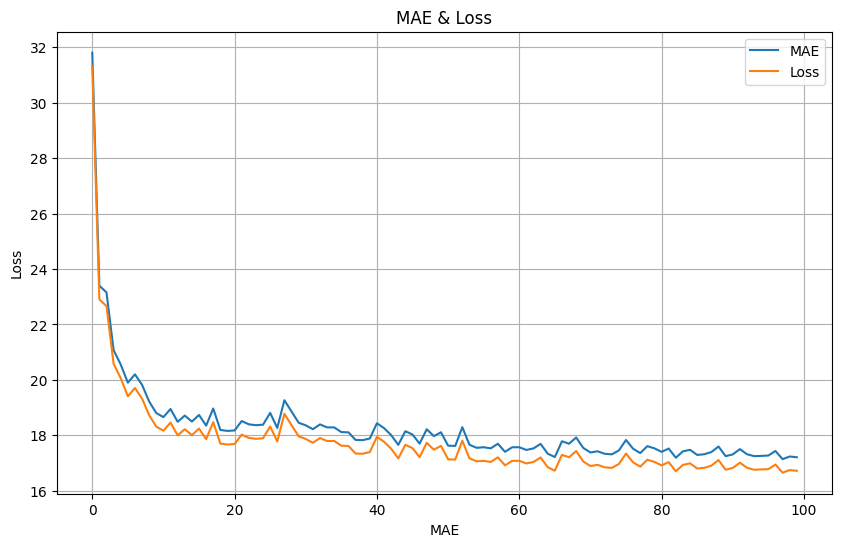

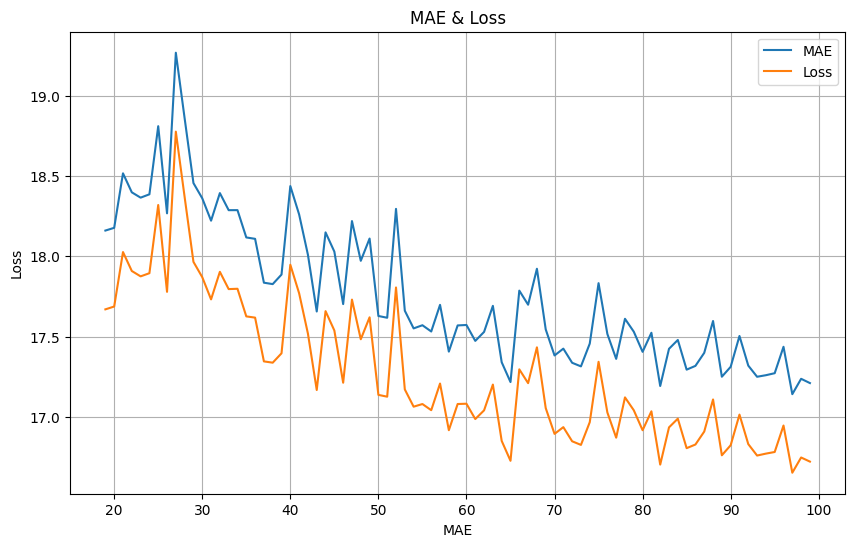

In [27]:
# Retrieve a list of list results on training & test data sets for each training epoch
mae       = history_s3c.history['mae']
loss      = history_s3c.history['loss']

# Plot MAE & Loss per epoch
epochs = range(len(loss))

plot_series(x=epochs, y=(mae, loss),
            title="MAE & Loss", xlabel="MAE", ylabel="Loss", legend=["MAE", "Loss"])

# Only plot the last 80% epochs
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed MAE & Loss per epoch
plot_series(x=epochs_zoom, y=(mae_zoom, loss_zoom),
            title="MAE & Loss", xlabel="MAE", ylabel="Loss", legend=["MAE", "Loss"])

8/8 [==============================] - 3s 22ms/step


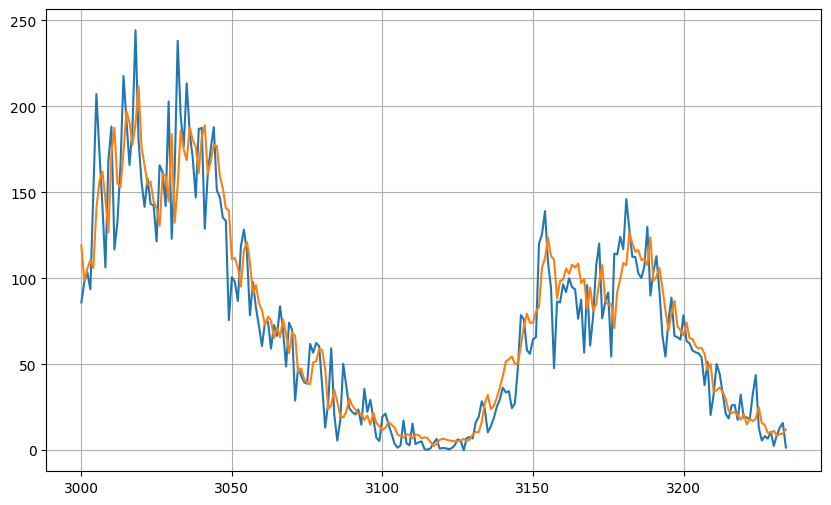

In [28]:
forecast_series = series[split_time-window_size : -1]
forecast = model_forecast(model_s3, forecast_series, window_size, batch_size)

results = forecast.squeeze()

plot_series(time_valid, (x_valid, results))

In [29]:
# print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

14.561294


Optional: another way to dynamically set the `learning_rate` -- when the model has been learning for some time, the *static* lr you set might no longer be optimal --> you might want to decrease it further to see better improvements (e.g., have your training loop gradually decay the lr per epoch, by either pass in a `lambda` function, or use `ExponentialDecay()` built-in scheduler from the Keras API.

In [30]:
### Static lr
# lr_schedule = tf.keras.callbacks.LearningRateScheduler(
#     lambda epoch: 1e-8 * 10**(epoch / 20)
# )

lr = 1e-7

optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9)

model_s3.compile(loss=tf.keras.losses.Huber(),
                 optimizer=optimizer,
                 metrics=["mae"])

history_s3c = model_s3.fit(train_set,
                           epochs=100)
                           # callbacks=[lr_schedule])

Epoch 1/100
93/93 [==============================] - 9s 50ms/step - loss: 16.3032 - mae: 16.7923
Epoch 2/100
93/93 [==============================] - 4s 37ms/step - loss: 16.2990 - mae: 16.7871
Epoch 3/100
93/93 [==============================] - 8s 84ms/step - loss: 16.2837 - mae: 16.7713
Epoch 4/100
93/93 [==============================] - 4s 38ms/step - loss: 16.2530 - mae: 16.7409
Epoch 5/100
93/93 [==============================] - 5s 49ms/step - loss: 16.2744 - mae: 16.7619
Epoch 6/100
93/93 [==============================] - 4s 37ms/step - loss: 16.2384 - mae: 16.7257
Epoch 7/100
93/93 [==============================] - 4s 37ms/step - loss: 16.2265 - mae: 16.7142
Epoch 8/100
93/93 [==============================] - 5s 48ms/step - loss: 16.2652 - mae: 16.7527
Epoch 9/100
93/93 [==============================] - 4s 37ms/step - loss: 16.2418 - mae: 16.7301
Epoch 10/100
93/93 [==============================] - 4s 40ms/step - loss: 16.2136 - mae: 16.7007
Epoch 11/100
93/93 [=========

In [31]:
### Dynamic lr
initial_lr = 1e-7

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_lr, decay_steps=400, decay_rate=0.96, staircase=True
)

optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

model_s3.compile(loss=tf.keras.losses.Huber(),
                 optimizer=optimizer,
                 metrics=["mae"])

history_s3cd = model_s3.fit(train_set,
                            epochs=40)
                            # callbacks=[lr_schedule])

Epoch 1/40
93/93 [==============================] - 9s 52ms/step - loss: 16.1018 - mae: 16.5887
Epoch 2/40
93/93 [==============================] - 4s 38ms/step - loss: 16.1357 - mae: 16.6231
Epoch 3/40
93/93 [==============================] - 5s 48ms/step - loss: 16.1307 - mae: 16.6176
Epoch 4/40
93/93 [==============================] - 4s 37ms/step - loss: 16.1432 - mae: 16.6291
Epoch 5/40
93/93 [==============================] - 4s 38ms/step - loss: 16.1078 - mae: 16.5947
Epoch 6/40
93/93 [==============================] - 4s 37ms/step - loss: 16.1299 - mae: 16.6170
Epoch 7/40
93/93 [==============================] - 4s 38ms/step - loss: 16.1084 - mae: 16.5946
Epoch 8/40
93/93 [==============================] - 5s 49ms/step - loss: 16.1614 - mae: 16.6482
Epoch 9/40
93/93 [==============================] - 4s 38ms/step - loss: 16.1695 - mae: 16.6574
Epoch 10/40
93/93 [==============================] - 4s 38ms/step - loss: 16.1106 - mae: 16.5979
Epoch 11/40
93/93 [====================

8/8 [==============================] - 1s 27ms/step


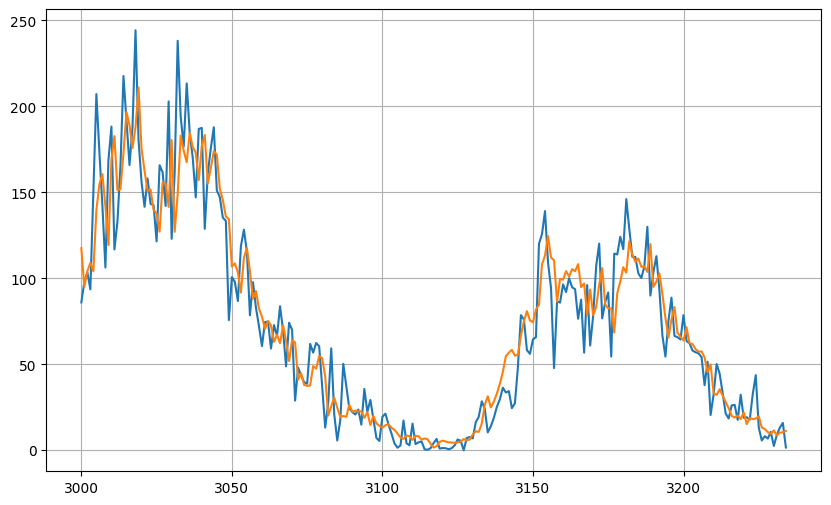

In [32]:
forecast_series = series[split_time-window_size : -1]
forecast = model_forecast(model_s3, forecast_series, window_size, batch_size)

results = forecast.squeeze()

plot_series(time_valid, (x_valid, results))

In [33]:
# print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

14.233129


## Ex. 4) Sunspots Prediction using Real-world Data

See Final Assignment notebook: C4W4_Assignment.ipynb